In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import joblib
from collections import Counter
from typing import Dict, Tuple, List, Union, Any
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score, confusion_matrix,
    accuracy_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.fft import fft

# ML Models imports
import xgboost as xgb
import lightgbm as lgb

# Deep Learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, Bidirectional
from tensorflow.keras.layers import Conv1D, Concatenate, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Add
from tensorflow.keras.layers import Reshape, Permute, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


# Constants and Configuration

In [ ]:
# Common activity labels in Russian
CLASS_NAMES = ['Отдых', 'Ходьба', 'Подъем по лестнице', 'Спуск по лестнице', 'Бег']

# Output directories configuration
OUTPUT_DIR = "/content"
XGBOOST_RESULTS_DIR = os.path.join(OUTPUT_DIR, "xgboost_results")
LGBM_RESULTS_DIR = os.path.join(OUTPUT_DIR, "lgbm_results")
CNN_RESULTS_DIR = os.path.join(OUTPUT_DIR, "cnn_results")
LSTM_RESULTS_DIR = os.path.join(OUTPUT_DIR, "lstm_results")
COMPARISON_DIR = os.path.join(OUTPUT_DIR, "model_comparison")

# Create all directories
for directory in [XGBOOST_RESULTS_DIR, LGBM_RESULTS_DIR, CNN_RESULTS_DIR, LSTM_RESULTS_DIR, COMPARISON_DIR]:
    os.makedirs(directory, exist_ok=True)

# Device configuration for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


# Common Data Loading and Processing Functions

In [ ]:
def load_and_stack_data(data_path: str, label_path: str) -> Tuple[np.ndarray, np.ndarray]:
    """
    Load and stack data from multiple files in the gait dataset.

    Args:
        data_path: Path to the directory containing data files
        label_path: Path to the directory containing label files

    Returns:
        Tuple of (stacked_data, stacked_labels)
    """
    data_files = sorted(os.listdir(data_path), key=lambda x: int(x.split('.')[0]))
    label_files = sorted(os.listdir(label_path), key=lambda x: int(x.split('.')[0]))
    X_stacked, y_stacked = None, None

    for data_file, label_file in zip(data_files, label_files):
        data_file_path = os.path.join(data_path, data_file)
        label_file_path = os.path.join(label_path, label_file)

        if data_file.split('.')[0] == label_file.split('.')[0]:
            data = np.loadtxt(data_file_path, delimiter='\t')
            labels = np.loadtxt(label_file_path, delimiter='\t')

            if X_stacked is None:
                X_stacked = data
                y_stacked = labels
            else:
                X_stacked = np.vstack((X_stacked, data))
                y_stacked = np.hstack((y_stacked, labels))

    return X_stacked, y_stacked

def extract_features_from_window(window_data: np.ndarray) -> Dict[str, float]:
    """
    Extract features from a time window for tree-based models.

    Args:
        window_data: Time series window data with shape [window_size, n_features]

    Returns:
        Dictionary of extracted features
    """
    features = {}

    # Separate data for each axis
    accel_x = window_data[:, 0]
    accel_y = window_data[:, 1]
    accel_z = window_data[:, 2]
    accel_abs = window_data[:, 3]

    # Define Russian axis names
    axis_names = ["Ось_X", "Ось_Y", "Ось_Z", "Абс_ускорение"]

    # Extract features for each axis
    for idx, (axis_data, axis_name) in enumerate(zip([accel_x, accel_y, accel_z, accel_abs], axis_names)):
        # Basic statistical features
        features[f"{axis_name}_среднее"] = np.mean(axis_data)  # mean
        features[f"{axis_name}_стд"] = np.std(axis_data)  # std
        features[f"{axis_name}_макс"] = np.max(axis_data)  # max
        features[f"{axis_name}_мин"] = np.min(axis_data)  # min
        features[f"{axis_name}_диапазон"] = np.max(axis_data) - np.min(axis_data)  # range
        features[f"{axis_name}_медиана"] = np.median(axis_data)  # median
        features[f"{axis_name}_Q25"] = np.percentile(axis_data, 25)  # 25th percentile
        features[f"{axis_name}_Q75"] = np.percentile(axis_data, 75)  # 75th percentile
        features[f"{axis_name}_IQR"] = features[f"{axis_name}_Q75"] - features[f"{axis_name}_Q25"]  # IQR

        # Higher-order statistics
        features[f"{axis_name}_асимметрия"] = skew(axis_data)  # skewness
        features[f"{axis_name}_эксцесс"] = kurtosis(axis_data)  # kurtosis

        # Differential features
        diff = np.diff(axis_data)
        features[f"{axis_name}_дифф_среднее"] = np.mean(diff)  # diff mean
        features[f"{axis_name}_дифф_стд"] = np.std(diff)  # diff std
        features[f"{axis_name}_дифф_макс"] = np.max(diff)  # diff max
        features[f"{axis_name}_дифф_мин"] = np.min(diff)  # diff min

        # Peak features
        peaks, _ = find_peaks(axis_data)
        if len(peaks) > 0:
            features[f"{axis_name}_пики_кол"] = len(peaks)  # peak count
            features[f"{axis_name}_пики_среднее"] = np.mean(axis_data[peaks])  # peak mean
        else:
            features[f"{axis_name}_пики_кол"] = 0
            features[f"{axis_name}_пики_среднее"] = 0

        # Frequency domain features
        fft_values = np.abs(fft(axis_data))
        freq_domain = fft_values[:len(axis_data)//2]
        features[f"{axis_name}_БПФ_среднее"] = np.mean(freq_domain)  # FFT mean
        features[f"{axis_name}_БПФ_стд"] = np.std(freq_domain)  # FFT std
        features[f"{axis_name}_БПФ_макс"] = np.max(freq_domain)  # FFT max

    # Cross-axis features (correlations)
    axis_pairs = [
        (0, 1, "Корр_X_Y"),  # X-Y correlation
        (0, 2, "Корр_X_Z"),  # X-Z correlation
        (0, 3, "Корр_X_Абс"),  # X-Abs correlation
        (1, 2, "Корр_Y_Z"),  # Y-Z correlation
        (1, 3, "Корр_Y_Абс"),  # Y-Abs correlation
        (2, 3, "Корр_Z_Абс")   # Z-Abs correlation
    ]

    for i, j, name in axis_pairs:
        axis_i = window_data[:, i]
        axis_j = window_data[:, j]
        features[name] = np.corrcoef(axis_i, axis_j)[0, 1]

    return features

def create_windowed_dataset_features(X: np.ndarray, y: np.ndarray, window_size: int, step_size: int) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Create sliding window features dataset for tree-based models.

    Args:
        X: Input data with shape [n_samples, n_features]
        y: Labels with shape [n_samples]
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Tuple of (features_dataframe, labels_array)
    """
    features_list = []
    labels = []

    # Create sliding windows
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_label = y[start]  # Use first label of window

        # Extract features
        window_features = extract_features_from_window(window_data)
        features_list.append(window_features)
        labels.append(window_label)

    # Convert to DataFrame and array
    features_df = pd.DataFrame(features_list)
    labels_array = np.array(labels)

    return features_df, labels_array

def create_windowed_dataset_sequences(X: np.ndarray, y: np.ndarray, window_size: int, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Create sliding window sequences for deep learning models.

    Args:
        X: Input data with shape [n_samples, n_features]
        y: Labels with shape [n_samples]
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Tuple of (sequences_array, labels_array)
    """
    sequences = []
    labels = []

    # Create sliding windows
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_label = y[start]  # Use first label of window

        # Save window and label
        sequences.append(window_data)
        labels.append(window_label)

    # Convert to numpy arrays
    sequences_array = np.array(sequences)
    labels_array = np.array(labels)

    return sequences_array, labels_array

def create_class_weights(labels: np.ndarray, beta: float = 0.9999) -> Dict[int, float]:
    """
    Create class weights to handle class imbalance.

    Args:
        labels: Array of labels
        beta: Parameter for effective number calculation

    Returns:
        Dictionary of class weights
    """
    # Get class counts
    class_counts = Counter(labels)
    total_samples = len(labels)
    n_classes = len(class_counts)

    # Calculate weights using effective number
    weights = {}

    for class_id, count in class_counts.items():
        # Calculate effective number
        effective_num = 1.0 - beta ** count
        weights[class_id] = (1.0 - beta) / effective_num

    # Enhance weights for minority classes
    max_weight = max(weights.values())
    for class_id, count in class_counts.items():
        # Give extra weight to classes with less than 10% samples
        if count / total_samples < 0.1:
            weights[class_id] *= 1.5

    # Normalize weights
    weight_sum = sum(weights.values())
    for class_id in weights:
        weights[class_id] = weights[class_id] / weight_sum * n_classes

    print(f"Class weights: {weights}")
    return weights

def analyze_class_distribution(y_train: np.ndarray) -> None:
    """
    Analyze and display class distribution.

    Args:
        y_train: Training labels
    """
    class_counts = np.bincount(y_train.astype(int))

    print("\nClass distribution analysis:")
    for i, (name, count) in enumerate(zip(CLASS_NAMES, class_counts)):
        print(f"Class {i} ({name}): {count} samples ({count/len(y_train)*100:.2f}%)")

    # Plot class distribution
    plt.figure(figsize=(10, 6))
    plt.bar(CLASS_NAMES, class_counts, color='skyblue')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)

    # Add count labels on bars
    for i, count in enumerate(class_counts):
        plt.text(i, count + 5, str(count), ha='center')

    plt.tight_layout()
    plt.savefig(os.path.join(COMPARISON_DIR, 'class_distribution.png'))
    plt.show()

# XGBoost Model Functions


In [ ]:
def preprocess_and_train_xgboost(X_train: pd.DataFrame, y_train: np.ndarray,
                                X_val: pd.DataFrame, y_val: np.ndarray) -> Tuple[xgb.Booster, StandardScaler, Dict]:
    """
    Preprocess data and train XGBoost model.

    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels

    Returns:
        Tuple of (trained_model, scaler, evaluation_results)
    """
    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Create XGBoost data matrices
    dtrain = xgb.DMatrix(X_train_scaled, label=y_train)
    dval = xgb.DMatrix(X_val_scaled, label=y_val)

    # Define XGBoost parameters
    params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': 5,  # 5 classes: resting, walking, climbing stairs, descending stairs, running
        'learning_rate': 0.1,
        'max_depth': 6,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'reg_alpha': 0,
        'reg_lambda': 1,
        'seed': 42
    }

    # Train XGBoost model
    evals = [(dtrain, 'train'), (dval, 'validation')]
    evals_result = {}

    print("Starting XGBoost model training...")
    start_time = time.time()

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        evals=evals,
        early_stopping_rounds=50,
        evals_result=evals_result,
        verbose_eval=100
    )

    training_time = time.time() - start_time
    print(f"Training completed! Time: {training_time:.2f} seconds")
    print(f"Best iteration: {model.best_iteration}")

    return model, scaler, evals_result

def evaluate_xgboost_model(model: xgb.Booster, X_test: pd.DataFrame, y_test: np.ndarray,
                          scaler: StandardScaler) -> Dict[str, Any]:
    """
    Evaluate XGBoost model.

    Args:
        model: Trained XGBoost model
        X_test: Test features
        y_test: Test labels
        scaler: Fitted StandardScaler

    Returns:
        Dictionary of evaluation metrics
    """
    # Standardize test data
    X_test_scaled = scaler.transform(X_test)
    dtest = xgb.DMatrix(X_test_scaled)

    # Predict
    y_probs = model.predict(dtest)
    y_pred = np.argmax(y_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report
    report = classification_report(y_test, y_pred,
                                 target_names=CLASS_NAMES,
                                 output_dict=True)

    # F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 score: {f1:.4f}")

    # Per-class F1 scores
    f1_per_class = f1_score(y_test, y_pred, average=None)
    for i, score in enumerate(f1_per_class):
        print(f"F1 score for class {i} ({CLASS_NAMES[i]}): {score:.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'f1_score': f1,
        'f1_per_class': f1_per_class,
        'predictions': y_pred,
        'probabilities': y_probs
    }

def plot_xgboost_results(model: xgb.Booster, feature_names: List[str],
                         evals_result: Dict, eval_results: Dict[str, Any]) -> None:
    """
    Plot XGBoost results.

    Args:
        model: Trained XGBoost model
        feature_names: Names of features
        evals_result: Training history
        eval_results: Evaluation metrics
    """
    # 1. Feature importance
    importance = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': list(importance.keys()),
        'Importance': list(importance.values())
    })

    # Try to map XGBoost internal feature names (f0, f1, f2...) to our feature names
    feature_map = {}
    for i, name in enumerate(feature_names):
        feature_map[f'f{i}'] = name

    # Apply mapping
    importance_df['Feature'] = importance_df['Feature'].map(lambda x: feature_map.get(x, x))

    # Sort and show top 20 most important features
    importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 20 Most Important Features (Information Gain)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_feature_importance.png"))
    plt.show()

    # 2. Confusion matrix
    cm = eval_results['confusion_matrix']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=CLASS_NAMES,
               yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_confusion_matrix.png"))
    plt.show()

    # 3. Training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    epochs = len(evals_result['train']['mlogloss'])
    x_axis = range(0, epochs)
    plt.plot(x_axis, evals_result['train']['mlogloss'], label='Training')
    plt.plot(x_axis, evals_result['validation']['mlogloss'], label='Validation')
    plt.title('XGBoost Log Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True)

    # Learning curve
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, [1 - loss for loss in evals_result['train']['mlogloss']], label='Training')
    plt.plot(x_axis, [1 - loss for loss in evals_result['validation']['mlogloss']], label='Validation')
    plt.title('XGBoost Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_training_history.png"))
    plt.show()

    # 4. Per-class F1 scores
    f1_per_class = eval_results['f1_per_class']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(CLASS_NAMES, f1_per_class, color='skyblue')
    plt.title('F1 Score by Class (XGBoost)')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_f1_scores.png"))
    plt.show()

def visualize_xgboost_sequence_predictions(X_unknown: np.ndarray, y_unknown: np.ndarray,
                                         model: xgb.Booster, scaler: StandardScaler,
                                         window_size: int, step_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Visualize sequence predictions from XGBoost model.

    Args:
        X_unknown: Input data for prediction
        y_unknown: True labels
        model: Trained XGBoost model
        scaler: Fitted StandardScaler
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Tuple of (predictions, true_labels)
    """
    # Full stride prediction
    features_list = []

    for start in range(0, len(X_unknown) - window_size + 1, step_size):
        end = start + window_size
        window_data = X_unknown[start:end]

        # Extract features
        window_features = extract_features_from_window(window_data)
        features_list.append(window_features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Standardize
    features_scaled = scaler.transform(features_df)
    dfeatures = xgb.DMatrix(features_scaled)

    # Predict
    y_probs = model.predict(dfeatures)
    y_pred = np.argmax(y_probs, axis=1)

    # Visualize prediction results
    plt.figure(figsize=(20, 6))

    # True labels
    true_indices = np.arange(0, len(y_unknown), step_size)[:len(y_pred)]
    true_labels = y_unknown[true_indices]

    # Plot prediction vs true comparison
    plt.plot(true_labels, 'b-', label='True Labels', alpha=0.5)
    plt.plot(y_pred, 'r-', label='Predicted Labels')
    plt.title('Sequence Prediction Results (XGBoost)')
    plt.xlabel('Window Index')
    plt.ylabel('Activity Label')
    plt.yticks([0, 1, 2, 3, 4], CLASS_NAMES)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_sequence_prediction.png"))
    plt.show()

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Sequence prediction accuracy: {accuracy:.4f}")

    return y_pred, true_labels

def run_xgboost_pipeline(X_train: pd.DataFrame, y_train: np.ndarray,
                       X_val: pd.DataFrame, y_val: np.ndarray,
                       X_test: pd.DataFrame, y_test: np.ndarray,
                       X_stacked: np.ndarray, y_stacked: np.ndarray,
                       window_size: int, step_size: int) -> Dict[str, Any]:
    """
    Run complete XGBoost pipeline.

    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        X_stacked, y_stacked: Full stacked data
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Dictionary of results
    """
    print("\n========== XGBoost Model Pipeline ==========")

    # Train XGBoost model
    model, scaler, evals_result = preprocess_and_train_xgboost(X_train, y_train, X_val, y_val)

    # Evaluate model
    eval_results = evaluate_xgboost_model(model, X_test, y_test, scaler)

    # Plot results
    plot_xgboost_results(model, X_train.columns, evals_result, eval_results)

    # Sequence prediction visualization
    sequence_preds, true_sequence = visualize_xgboost_sequence_predictions(
        X_stacked, y_stacked, model, scaler, window_size, step_size
    )

    # Save model and scaler
    joblib.dump(model, os.path.join(XGBOOST_RESULTS_DIR, 'xgboost_model.pkl'))
    joblib.dump(scaler, os.path.join(XGBOOST_RESULTS_DIR, 'xgboost_scaler.pkl'))
    print("Model and scaler saved.")

    # Save evaluation results
    with open(os.path.join(XGBOOST_RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        # Convert numpy objects to Python types for JSON serialization
        results = {
            'accuracy': float(eval_results['accuracy']),
            'f1_score': float(eval_results['f1_score']),
            'f1_per_class': eval_results['f1_per_class'].tolist(),
            'classification_report': eval_results['classification_report'],
            'confusion_matrix': eval_results['confusion_matrix'].tolist(),
            'sequence_accuracy': float(accuracy_score(true_sequence, sequence_preds))
        }
        json.dump(results, f, indent=4)

    return eval_results

# LightGBM Model Functions

In [ ]:
def preprocess_and_train_lgbm(X_train, y_train, X_val, y_val):
    """
    Preprocess data and train LightGBM model.

    Args:
        X_train: Training features
        y_train: Training labels
        X_val: Validation features
        y_val: Validation labels

    Returns:
        Tuple of (trained_model, scaler, evaluation_results)
    """
    # Feature standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Create LightGBM datasets
    lgb_train = lgb.Dataset(X_train_scaled, label=y_train)
    lgb_val = lgb.Dataset(X_val_scaled, label=y_val, reference=lgb_train)

    # Calculate class weights to handle imbalance
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}

    # Assign weight to each sample
    sample_weights = np.ones_like(y_train, dtype=np.float32)
    for idx, label in enumerate(y_train):
        sample_weights[idx] = class_weight_dict[label]

    # Set sample weights
    lgb_train.set_weight(sample_weights)

    # Define LightGBM parameters
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': 5,  # 5 classes: resting, walking, climbing stairs, descending stairs, running
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'max_depth': 7,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 50,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'seed': 42
    }

    # Check if GPU is available
    try:
        import GPUtil
        if len(GPUtil.getGPUs()) > 0:
            params.update({
                'device': 'gpu',
                'gpu_platform_id': 0,
                'gpu_device_id': 0,
                'max_bin': 63
            })
            print("GPU training enabled!")
    except:
        print("GPU not detected, using CPU.")

    # Training callbacks
    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=20)
    ]

    # Train LightGBM model
    evals_result = {}

    print("Starting LightGBM model training...")
    start_time = time.time()

    # Create callback to record evaluation results
    record_eval = lgb.record_evaluation(evals_result)

    model = lgb.train(
        params=params,
        train_set=lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        valid_names=['train', 'validation'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=True),
            lgb.log_evaluation(period=20),
            record_eval
        ]
    )

    training_time = time.time() - start_time
    print(f"Training completed! Time: {training_time:.2f} seconds")
    print(f"Best iteration: {model.best_iteration}")

    return model, scaler, evals_result

def evaluate_lgbm_model(model, X_test, y_test, scaler):
    """
    Evaluate LightGBM model.

    Args:
        model: Trained LightGBM model
        X_test: Test features
        y_test: Test labels
        scaler: Fitted StandardScaler

    Returns:
        Dictionary of evaluation metrics
    """
    # Standardize test data
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_probs = model.predict(X_test_scaled, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_probs, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy: {accuracy:.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Classification report
    report = classification_report(y_test, y_pred,
                                 target_names=CLASS_NAMES,
                                 output_dict=True)

    # F1 score
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Weighted F1 score: {f1:.4f}")

    # Per-class F1 scores
    f1_per_class = f1_score(y_test, y_pred, average=None)
    for i, score in enumerate(f1_per_class):
        print(f"F1 score for class {i} ({CLASS_NAMES[i]}): {score:.4f}")

    return {
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'classification_report': report,
        'f1_score': f1,
        'f1_per_class': f1_per_class,
        'predictions': y_pred,
        'probabilities': y_probs
    }

def plot_lgbm_results(model, feature_names, evals_result, eval_results):
    """
    Plot LightGBM results.

    Args:
        model: Trained LightGBM model
        feature_names: Names of features
        evals_result: Training history
        eval_results: Evaluation metrics
    """
    # 1. Feature importance
    importance = model.feature_importance(importance_type='gain')
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    })

    # Sort and show top 20 most important features
    importance_df = importance_df.sort_values('Importance', ascending=False).head(20)

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Top 20 Most Important Features (Information Gain)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_feature_importance.png"))
    plt.show()

    # 2. Confusion matrix
    cm = eval_results['confusion_matrix']
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=CLASS_NAMES,
               yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_confusion_matrix.png"))
    plt.show()

    # 3. Training history
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    epochs = len(evals_result['train']['multi_logloss'])
    x_axis = range(0, epochs)
    plt.plot(x_axis, evals_result['train']['multi_logloss'], label='Training')
    plt.plot(x_axis, evals_result['validation']['multi_logloss'], label='Validation')
    plt.title('LightGBM Log Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Log Loss')
    plt.legend()
    plt.grid(True)

    # Learning curve
    plt.subplot(1, 2, 2)
    plt.plot(x_axis, [1 - loss for loss in evals_result['train']['multi_logloss']], label='Training')
    plt.plot(x_axis, [1 - loss for loss in evals_result['validation']['multi_logloss']], label='Validation')
    plt.title('LightGBM Learning Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Performance')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_training_history.png"))
    plt.show()

    # 4. Per-class F1 scores
    f1_per_class = eval_results['f1_per_class']

    plt.figure(figsize=(10, 6))
    bars = plt.bar(CLASS_NAMES, f1_per_class, color='skyblue')
    plt.title('F1 Score by Class (LightGBM)')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_f1_scores.png"))
    plt.show()

def visualize_lgbm_sequence_predictions(X_unknown, y_unknown, model, scaler, window_size, step_size):
    """
    Visualize sequence predictions from LightGBM model.

    Args:
        X_unknown: Input data for prediction
        y_unknown: True labels
        model: Trained LightGBM model
        scaler: Fitted StandardScaler
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Tuple of (predictions, true_labels)
    """
    # Full stride prediction
    features_list = []

    for start in range(0, len(X_unknown) - window_size + 1, step_size):
        end = start + window_size
        window_data = X_unknown[start:end]

        # Extract features
        window_features = extract_features_from_window(window_data)
        features_list.append(window_features)

    # Convert to DataFrame
    features_df = pd.DataFrame(features_list)

    # Standardize
    features_scaled = scaler.transform(features_df)

    # Predict
    y_probs = model.predict(features_scaled, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_probs, axis=1)

    # Visualize prediction results
    plt.figure(figsize=(20, 6))

    # True labels
    true_indices = np.arange(0, len(y_unknown), step_size)[:len(y_pred)]
    true_labels = y_unknown[true_indices]

    # Plot prediction vs true comparison
    plt.plot(true_labels, 'b-', label='True Labels', alpha=0.5)
    plt.plot(y_pred, 'r-', label='Predicted Labels')
    plt.title('Sequence Prediction Results (LightGBM)')
    plt.xlabel('Window Index')
    plt.ylabel('Activity Label')
    plt.yticks([0, 1, 2, 3, 4], CLASS_NAMES)
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_sequence_prediction.png"))
    plt.show()

    # Calculate accuracy
    accuracy = accuracy_score(true_labels, y_pred)
    print(f"Sequence prediction accuracy: {accuracy:.4f}")

    return y_pred, true_labels

def run_lgbm_pipeline(X_train, y_train, X_val, y_val, X_test, y_test,
                     X_stacked, y_stacked, window_size, step_size):
    """
    Run complete LightGBM pipeline.

    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        X_stacked, y_stacked: Full stacked data
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Dictionary of results
    """
    print("\n========== LightGBM Model Pipeline ==========")

    # Train LightGBM model
    model, scaler, evals_result = preprocess_and_train_lgbm(X_train, y_train, X_val, y_val)

    # Evaluate model
    eval_results = evaluate_lgbm_model(model, X_test, y_test, scaler)

    # Plot results
    plot_lgbm_results(model, X_train.columns, evals_result, eval_results)

    # Sequence prediction visualization
    sequence_preds, true_sequence = visualize_lgbm_sequence_predictions(
        X_stacked, y_stacked, model, scaler, window_size, step_size
    )

    # Save model and scaler
    model_path = os.path.join(LGBM_RESULTS_DIR, "lgbm_model.txt")
    model.save_model(model_path)
    scaler_path = os.path.join(LGBM_RESULTS_DIR, "lgbm_scaler.pkl")
    joblib.dump(scaler, scaler_path)
    print("Model and scaler saved.")

    # Save evaluation results
    with open(os.path.join(LGBM_RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        # Convert numpy objects to Python types for JSON serialization
        results = {
            'accuracy': float(eval_results['accuracy']),
            'f1_score': float(eval_results['f1_score']),
            'f1_per_class': eval_results['f1_per_class'].tolist(),
            'classification_report': eval_results['classification_report'],
            'confusion_matrix': eval_results['confusion_matrix'].tolist(),
            'sequence_accuracy': float(accuracy_score(true_sequence, sequence_preds))
        }
        json.dump(results, f, indent=4)

    return eval_results

# CNN Model Functions

In [ ]:
# Residual block for CNN model
class ResidualBlock(nn.Module):
    """Residual block for improved gradient flow."""
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
        super(ResidualBlock, self).__init__()

        # First convolutional layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                              stride=stride, padding=kernel_size//2, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        # Second convolutional layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                              stride=1, padding=kernel_size//2, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# CNN model definition
class GaitCNN(nn.Module):
    def __init__(self, input_channels=4, num_classes=5, dropout_rate=0.5):
        super(GaitCNN, self).__init__()

        # Input layer conversion
        self.input_conv = nn.Conv1d(input_channels, 32, kernel_size=7, stride=1, padding=3, bias=False)
        self.input_bn = nn.BatchNorm1d(32)

        # Residual blocks
        self.res_block1 = ResidualBlock(32, 64, kernel_size=5, stride=2)
        self.res_block2 = ResidualBlock(64, 128, kernel_size=5, stride=2)
        self.res_block3 = ResidualBlock(128, 256, kernel_size=3, stride=2)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Conv1d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

        # Pooling and fully connected layers
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # Input layer
        x = F.relu(self.input_bn(self.input_conv(x)))

        # Residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)

        # Attention mechanism
        attention = self.attention(x)
        x = x * attention

        # Global pooling
        x = self.global_pool(x).squeeze(-1)

        # Fully connected layers
        x = self.fc(x)

        return x

def create_dataloaders(train_X, train_y, val_X, val_y, test_X, test_y,
                      batch_size=32, use_weighted_sampler=True):
    """
    Create data loaders for PyTorch models.

    Args:
        train_X, train_y: Training data
        val_X, val_y: Validation data
        test_X, test_y: Test data
        batch_size: Batch size
        use_weighted_sampler: Whether to use weighted sampling

    Returns:
        Tuple of (train_loader, val_loader, test_loader)
    """
    # Transpose data to match CNN input format [batch, sequence_length, channels] -> [batch, channels, sequence_length]
    train_X_t = np.transpose(train_X, (0, 2, 1))
    val_X_t = np.transpose(val_X, (0, 2, 1))
    test_X_t = np.transpose(test_X, (0, 2, 1))

    print(f"Training data shape after transposition: {train_X_t.shape}")

    # Create datasets
    train_dataset = TensorDataset(torch.tensor(train_X_t, dtype=torch.float32), torch.tensor(train_y, dtype=torch.long))
    val_dataset = TensorDataset(torch.tensor(val_X_t, dtype=torch.float32), torch.tensor(val_y, dtype=torch.long))
    test_dataset = TensorDataset(torch.tensor(test_X_t, dtype=torch.float32), torch.tensor(test_y, dtype=torch.long))

    # Create data loaders
    if use_weighted_sampler:
        # Use weighted sampler to handle class imbalance
        class_weights_dict = create_class_weights(train_y)
        class_weights = [class_weights_dict[i] for i in range(len(np.unique(train_y)))]

        sample_weights = [class_weights[int(label)] for label in train_y]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

def train_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train one epoch.

    Args:
        model: Neural network model
        train_loader: Training data loader
        criterion: Loss function
        optimizer: Optimizer
        device: Device (CPU/GPU)

    Returns:
        Tuple of (epoch_loss, epoch_accuracy)
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate epoch average loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device):
    """
    Validate model.

    Args:
        model: Neural network model
        val_loader: Validation data loader
        criterion: Loss function
        device: Device (CPU/GPU)

    Returns:
        Tuple of (val_loss, val_accuracy, val_f1, predictions, true_labels)
    """
    model.eval()
    running_loss = 0.0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            # Collect predictions and true labels
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Calculate average loss
    val_loss = running_loss / len(val_loader)

    # Calculate accuracy
    val_acc = sum(np.array(predictions) == np.array(true_labels)) / len(true_labels)

    # Calculate F1 score
    val_f1 = f1_score(true_labels, predictions, average='weighted')

    return val_loss, val_acc, val_f1, predictions, true_labels

def train_cnn_model(model, train_loader, val_loader, criterion, optimizer, scheduler,
                   num_epochs=50, patience=10, device=None):
    """
    Complete training process with early stopping.

    Args:
        model: Neural network model
        train_loader, val_loader: Data loaders
        criterion: Loss function
        optimizer: Optimizer
        scheduler: Learning rate scheduler
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        device: Device (CPU/GPU)

    Returns:
        Tuple of (trained_model, training_history)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize training history
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    # Early stopping variables
    best_val_f1 = 0
    early_stop_counter = 0

    # Path to save best model
    best_model_path = os.path.join(CNN_RESULTS_DIR, 'best_model.pth')

    print(f"Starting training for {num_epochs} epochs...")

    # Training loop
    for epoch in range(num_epochs):
        start_time = time.time()

        # Train one epoch
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1, predictions, true_labels = validate(model, val_loader, criterion, device)

        # Update learning rate
        if hasattr(scheduler, 'step'):
            if scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Calculate time
        epoch_time = time.time() - start_time

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Time: {epoch_time:.2f}s, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_acc:.4f}, "
              f"Val F1: {val_f1:.4f}")

        # Early stopping check
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            early_stop_counter = 0
            # Save best model
            torch.save(model.state_dict(), best_model_path)
            print(f"Best model saved with F1: {val_f1:.4f}")
        else:
            early_stop_counter += 1
            print(f"F1 not improving: {early_stop_counter}/{patience}")

            if early_stop_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Load best model
    model.load_state_dict(torch.load(best_model_path))

    return model, history

def test_cnn_model(model, test_loader, device=None):
    """
    Test model and return evaluation metrics.

    Args:
        model: Neural network model
        test_loader: Test data loader
        device: Device (CPU/GPU)

    Returns:
        Dictionary of evaluation metrics
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    predictions = []
    true_labels = []
    probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs.data, 1)

            # Collect predictions and true labels
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    probabilities = np.array(probabilities)

    # Calculate evaluation metrics
    accuracy = np.mean(predictions == true_labels)
    f1 = f1_score(true_labels, predictions, average='weighted')
    f1_per_class = f1_score(true_labels, predictions, average=None)

    # Confusion matrix
    cm = confusion_matrix(true_labels, predictions)

    # Classification report
    report = classification_report(true_labels, predictions,
                                 target_names=CLASS_NAMES,
                                 output_dict=True)

    # ROC AUC
    try:
        # Multiclass ROC AUC
        n_classes = len(np.unique(true_labels))
        y_true_onehot = np.zeros((len(true_labels), n_classes))
        for i in range(len(true_labels)):
            y_true_onehot[i, true_labels[i]] = 1

        auc_score = roc_auc_score(y_true_onehot, probabilities, multi_class='ovr')
    except Exception as e:
        print(f"Error calculating ROC AUC: {e}")
        auc_score = None

    # Print results
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Weighted F1 score: {f1:.4f}")
    print(f"F1 score for each class: {f1_per_class}")
    if auc_score:
        print(f"ROC AUC: {auc_score:.4f}")

    return {
        'accuracy': accuracy,
        'f1_weighted': f1,
        'f1_per_class': f1_per_class,
        'confusion_matrix': cm,
        'classification_report': report,
        'auc_score': auc_score,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities
    }

def visualize_cnn_results(history, evaluation_results):
    """
    Visualize training history and evaluation results.

    Args:
        history: Training history
        evaluation_results: Evaluation metrics
    """
    # Create a large figure
    plt.figure(figsize=(20, 15))

    # 1. Training and validation loss
    plt.subplot(3, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Training and validation accuracy
    plt.subplot(3, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. Validation F1 score
    plt.subplot(3, 2, 3)
    plt.plot(history['val_f1'])
    plt.title('Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')

    # 4. Confusion matrix
    plt.subplot(3, 2, 4)
    cm = evaluation_results['confusion_matrix']
    activity_labels = ['Отдых', 'Ходьба', 'Подъем', 'Спуск', 'Бег']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=activity_labels,
               yticklabels=activity_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    # 5. Class F1 scores
    plt.subplot(3, 2, 5)
    f1_per_class = evaluation_results['f1_per_class']
    sns.barplot(x=activity_labels, y=f1_per_class)
    plt.title('F1 Score for Each Class')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)

    # Save figure
    plt.tight_layout()
    plt.savefig(os.path.join(CNN_RESULTS_DIR, 'training_results.png'))
    plt.show()

    # ROC curve (if available)
    if evaluation_results['auc_score']:
        plt.figure(figsize=(10, 8))
        activity_labels = CLASS_NAMES
        y_true = evaluation_results['true_labels']
        y_probs = evaluation_results['probabilities']

        # Calculate ROC curve for each class
        n_classes = len(np.unique(y_true))
        y_true_onehot = np.zeros((len(y_true), n_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1

        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{activity_labels[i]} (AUC = {roc_auc:.4f})')

        # Add random prediction baseline
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve for Each Class')
        plt.legend(loc="lower right")

        plt.savefig(os.path.join(CNN_RESULTS_DIR, 'roc_curves.png'))
        plt.show()

def visualize_cnn_sequence_predictions(model, X_data, y_data, window_size, step_size, device=None):
    """
    Visualize sequence predictions from CNN model.

    Args:
        model: Trained CNN model
        X_data: Input data for prediction
        y_data: True labels
        window_size: Size of sliding window
        step_size: Step size for sliding window
        device: Device (CPU/GPU)

    Returns:
        Tuple of (predictions, true_labels, probabilities)
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create sliding window sequences
    sequences, true_labels = create_windowed_dataset_sequences(X_data, y_data, window_size, step_size)

    # Transpose data to match CNN input format
    sequences_t = np.transpose(sequences, (0, 2, 1))

    # Create PyTorch dataset and loader
    dataset = TensorDataset(torch.tensor(sequences_t, dtype=torch.float32), torch.tensor(true_labels, dtype=torch.long))
    loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # Predict
    model.eval()
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, _ in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    predictions = np.array(all_preds)
    probabilities = np.array(all_probs)

    # Calculate accuracy
    accuracy = np.mean(predictions == true_labels)
    print(f"Sequence prediction accuracy: {accuracy:.4f}")

    # Visualize results
    plt.figure(figsize=(20, 6))

    # Plot true vs predicted labels
    plt.plot(true_labels, 'b-', label='True Labels', alpha=0.5)
    plt.plot(predictions, 'r-', label='Predicted Labels')
    plt.title('Sequence Prediction Results (CNN)')
    plt.xlabel('Window Index')
    plt.ylabel('Activity Label')
    plt.yticks([0, 1, 2, 3, 4], CLASS_NAMES)
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(CNN_RESULTS_DIR, 'sequence_prediction.png'))
    plt.show()

    # Calculate statistics for each class
    class_stats = {}
    for i, label in enumerate(CLASS_NAMES):
        # Get true and predicted labels for this class
        mask_true = (true_labels == i)
        mask_pred = (predictions == i)

        # Correct predictions
        correct = np.sum((true_labels == i) & (predictions == i))

        # Total samples in this class
        total = np.sum(mask_true)

        # Predicted as this class
        predicted_as = np.sum(mask_pred)

        # Calculate metrics
        accuracy = correct / total if total > 0 else 0
        recall = correct / total if total > 0 else 0
        precision = correct / predicted_as if predicted_as > 0 else 0

        class_stats[label] = {
            'total': int(total),
            'correct': int(correct),
            'predicted_as': int(predicted_as),
            'accuracy': float(accuracy),
            'recall': float(recall),
            'precision': float(precision)
        }

    # Print statistics for each class
    print("\nClass statistics:")
    for label, stats in class_stats.items():
        print(f"{label}:")
        print(f"  Total samples: {stats['total']}")
        print(f"  Correct predictions: {stats['correct']}")
        print(f"  Predicted as this class: {stats['predicted_as']}")
        print(f"  Accuracy: {stats['accuracy']:.4f}")
        print(f"  Recall: {stats['recall']:.4f}")
        print(f"  Precision: {stats['precision']:.4f}")
        print()

    return predictions, true_labels, probabilities

def run_cnn_pipeline(X_train, y_train, X_val, y_val, X_test, y_test,
                    X_stacked, y_stacked, window_size, step_size):
    """
    Run complete CNN pipeline.

    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        X_stacked, y_stacked: Full stacked data
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Dictionary of results
    """
    print("\n========== CNN Model Pipeline ==========")

    # Create data loaders
    train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=32, use_weighted_sampler=True
    )

    # Initialize CNN model
    model = GaitCNN(input_channels=4, num_classes=5, dropout_rate=0.5).to(device)
    print(model)

    # Calculate class weights for loss function
    class_weights_dict = create_class_weights(y_train)
    class_weights = torch.FloatTensor([class_weights_dict[i] for i in range(len(np.unique(y_train)))]).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train model
    model, history = train_cnn_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=50, patience=10, device=device
    )

    # Test model
    evaluation_results = test_cnn_model(model, test_loader, device)

    # Visualize results
    visualize_cnn_results(history, evaluation_results)

    # Sequence prediction visualization
    sequence_preds, sequence_true, sequence_probs = visualize_cnn_sequence_predictions(
        model, X_stacked, y_stacked, window_size, step_size, device=device
    )

    # Save model
    model_path = os.path.join(CNN_RESULTS_DIR, 'final_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"\nModel saved to: {model_path}")

    # Save evaluation results
    results = {
        'accuracy': float(evaluation_results['accuracy']),
        'f1_weighted': float(evaluation_results['f1_weighted']),
        'f1_per_class': evaluation_results['f1_per_class'].tolist(),
        'classification_report': evaluation_results['classification_report'],
        'confusion_matrix': evaluation_results['confusion_matrix'].tolist(),
        'sequence_accuracy': float(accuracy_score(sequence_true, sequence_preds))
    }

    with open(os.path.join(CNN_RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(results, f, indent=4)

    print("Evaluation results saved.")

    return evaluation_results

# LSTM Model Functions

In [ ]:
def f1_metric(y_true, y_pred):
    """TensorFlow compatible F1 score calculation function."""
    # Get predicted classes
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true_classes = tf.argmax(y_true, axis=1)

    # Convert to float
    y_pred_classes = tf.cast(y_pred_classes, tf.float32)
    y_true_classes = tf.cast(y_true_classes, tf.float32)

    # Calculate TP, FP, FN
    true_positives = tf.reduce_sum(tf.cast(y_pred_classes == y_true_classes, tf.float32))

    # Add smoothing factor to avoid division by zero
    smooth = tf.constant(1e-7, dtype=tf.float32)

    # Calculate precision and recall
    precision = true_positives / (tf.reduce_sum(tf.ones_like(y_pred_classes)) + smooth)
    recall = true_positives / (tf.reduce_sum(tf.ones_like(y_true_classes)) + smooth)

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall + smooth)

    return f1

def attention_block(inputs):
    """Implement attention mechanism."""
    # Time dimension attention
    attention = Dense(1, activation='tanh')(inputs)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention)

    # Apply attention weights
    context = Multiply()([inputs, attention])

    return context

def build_lstm_model(input_shape, num_classes=5):
    """Build advanced LSTM model with attention."""
    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers for feature extraction
    conv1 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Concatenate()([conv1, conv2])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Attention mechanism
    x = attention_block(x)

    # Global pooling
    x = GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs, outputs)

    return model

def build_simple_lstm_model(input_shape, num_classes=5):
    """Build simple LSTM model."""
    model = Sequential([
        # Input layer
        LSTM(128, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),

        # Second LSTM layer
        LSTM(64),
        Dropout(0.3),

        # Fully connected layer
        Dense(64, activation='relu'),
        Dropout(0.3),

        # Output layer
        Dense(num_classes, activation='softmax')
    ])

    return model

def train_lstm_model(X_train, y_train, X_val, y_val, X_test, y_test, model_type="advanced"):
    """Train LSTM model."""
    print("Preparing data for LSTM training...")

    # Ensure labels are integer type
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

    # Convert labels to one-hot encoding
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=5)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=5)

    # Feature standardization using RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Get input shape and number of classes
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = 5  # 5 activity classes

    print(f"Input shape: {input_shape}")
    print(f"Number of classes: {num_classes}")

    # Build model
    if model_type == "advanced":
        print("Creating advanced LSTM model...")
        model = build_lstm_model(input_shape, num_classes)
    else:
        print("Creating simple LSTM model...")
        model = build_simple_lstm_model(input_shape, num_classes)

    # Calculate class weights
    class_weights = create_class_weights(y_train)

    # Optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_metric]
    )

    # Output model summary
    model.summary()

    # Callbacks
    callbacks = [
        # Learning rate scheduler
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.6,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor='val_f1_metric',
            patience=15,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        # Model checkpoint
        ModelCheckpoint(
            filepath=os.path.join(LSTM_RESULTS_DIR, "best_lstm_model.h5"),
            monitor='val_f1_metric',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    print("Starting LSTM model training...")
    history = model.fit(
        X_train_scaled, y_train_onehot,
        validation_data=(X_val_scaled, y_val_onehot),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Evaluate model
    print("Evaluating model on test set...")
    test_loss, test_accuracy, test_f1 = model.evaluate(X_test_scaled, y_test_onehot, verbose=1)

    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test F1 score: {test_f1:.4f}")

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Calculate detailed metrics
    f1 = f1_score(y_test, y_pred_classes, average='weighted')
    class_f1 = f1_score(y_test, y_pred_classes, average=None)

    # Output F1 score for each class
    for i, score in enumerate(class_f1):
        print(f"F1 score for class {i} ({CLASS_NAMES[i]}): {score:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Calculate ROC AUC
    try:
        y_test_onehot_np = y_test_onehot
        auc_score = roc_auc_score(y_test_onehot_np, y_pred, multi_class='ovr')
        print(f"AUC-ROC: {auc_score:.4f}")
    except Exception as e:
        print(f"Error calculating AUC-ROC: {e}")
        auc_score = None

    # Results data
    evaluation_results = {
        "test_accuracy": test_accuracy,
        "test_f1": test_f1,
        "f1_score": f1,
        "class_f1": class_f1.tolist(),
        "confusion_matrix": cm.tolist(),
        "auc_score": auc_score,
        "y_pred": y_pred_classes.tolist(),
        "y_true": y_test.tolist(),
        "y_pred_probs": y_pred.tolist(),
    }

    return model, history, evaluation_results, scaler

def visualize_lstm_results(history, evaluation_results):
    """Visualize training results and model performance."""
    # 1. Plot training history
    plt.figure(figsize=(15, 5))

    # Loss curves
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1 score curves
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_metric'], label='Training F1')
    plt.plot(history.history['val_f1_metric'], label='Validation F1')
    plt.title('Model F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(LSTM_RESULTS_DIR, "lstm_training_history.png"))
    plt.show()

    # 2. Confusion matrix
    cm = np.array(evaluation_results["confusion_matrix"])

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(LSTM_RESULTS_DIR, "lstm_confusion_matrix.png"))
    plt.show()

    # 3. Per-class F1 scores bar chart
    class_f1 = evaluation_results["class_f1"]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(CLASS_NAMES, class_f1, color='skyblue')
    plt.title('F1 Score by Class (LSTM)')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(LSTM_RESULTS_DIR, "lstm_class_f1_scores.png"))
    plt.show()

    # 4. Save classification report
    y_true = np.array(evaluation_results["y_true"])
    y_pred = np.array(evaluation_results["y_pred"])

    report = classification_report(y_true, y_pred,
                                  target_names=CLASS_NAMES,
                                  output_dict=True)

    # Save as JSON
    with open(os.path.join(LSTM_RESULTS_DIR, "lstm_classification_report.json"), "w") as f:
        json.dump(report, f, indent=4)

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

def visualize_lstm_sequence_predictions(model, X_data, y_data, window_size, step_size, scaler):
    """Visualize sequence predictions from LSTM model."""
    # Create sliding windows
    sequences, true_labels = create_windowed_dataset_sequences(X_data, y_data, window_size, step_size)

    # Standardize data
    X_scaled = scaler.transform(sequences.reshape(-1, sequences.shape[-1])).reshape(sequences.shape)

    # Predict
    y_probs = model.predict(X_scaled)
    y_pred = np.argmax(y_probs, axis=1)

    # Calculate accuracy
    accuracy = np.mean(y_pred == true_labels)
    print(f"Sequence prediction accuracy: {accuracy:.4f}")

    # Visualize results
    plt.figure(figsize=(20, 6))

    # Plot true labels and predicted labels
    plt.plot(true_labels, 'b-', label='True Labels', alpha=0.5)
    plt.plot(y_pred, 'r-', label='Predicted Labels')
    plt.title('Sequence Prediction Results (LSTM)')
    plt.xlabel('Window Index')
    plt.ylabel('Activity Label')
    plt.yticks([0, 1, 2, 3, 4], CLASS_NAMES)
    plt.legend()
    plt.grid(True)

    plt.savefig(os.path.join(LSTM_RESULTS_DIR, "lstm_sequence_prediction.png"))
    plt.show()

    # Calculate statistics for each class
    class_stats = {}
    for i, label in enumerate(CLASS_NAMES):
        # Calculate true and predicted masks for this class
        mask_true = (true_labels == i)
        mask_pred = (y_pred == i)

        # Calculate correct predictions
        correct = np.sum((true_labels == i) & (y_pred == i))

        # Calculate total samples in this class
        total = np.sum(mask_true)

        # Calculate samples predicted as this class
        predicted_as = np.sum(mask_pred)

        # Calculate accuracy, recall, and precision
        accuracy = correct / total if total > 0 else 0
        recall = correct / total if total > 0 else 0
        precision = correct / predicted_as if predicted_as > 0 else 0

        class_stats[label] = {
            'total': int(total),
            'correct': int(correct),
            'predicted_as': int(predicted_as),
            'accuracy': float(accuracy),
            'recall': float(recall),
            'precision': float(precision)
        }

    # Print statistics for each class
    print("\nClass Statistics:")
    for label, stats in class_stats.items():
        print(f"{label}:")
        print(f"  Total samples: {stats['total']}")
        print(f"  Correct predictions: {stats['correct']}")
        print(f"  Predicted as this class: {stats['predicted_as']}")
        print(f"  Accuracy: {stats['accuracy']:.4f}")
        print(f"  Recall: {stats['recall']:.4f}")
        print(f"  Precision: {stats['precision']:.4f}")
        print()

    return y_pred, true_labels

def run_lstm_pipeline(X_train, y_train, X_val, y_val, X_test, y_test,
                     X_stacked, y_stacked, window_size, step_size):
    """
    Run complete LSTM pipeline.

    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data
        X_test, y_test: Test data
        X_stacked, y_stacked: Full stacked data
        window_size: Size of sliding window
        step_size: Step size for sliding window

    Returns:
        Dictionary of results
    """
    print("\n========== LSTM Model Pipeline ==========")

    # Train LSTM model
    model, history, evaluation_results, scaler = train_lstm_model(
        X_train, y_train, X_val, y_val, X_test, y_test, model_type="advanced"
    )

    # Visualize results
    visualize_lstm_results(history, evaluation_results)

    # Sequence prediction visualization
    sequence_preds, true_sequence = visualize_lstm_sequence_predictions(
        model, X_stacked, y_stacked, window_size, step_size, scaler
    )

    # Save model and scaler
    model_path = os.path.join(LSTM_RESULTS_DIR, "final_lstm_model.h5")
    model.save(model_path)
    scaler_path = os.path.join(LSTM_RESULTS_DIR, "lstm_scaler.joblib")
    joblib.dump(scaler, scaler_path)
    print(f"Model saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")

    # Save evaluation results
    results_path = os.path.join(LSTM_RESULTS_DIR, "lstm_evaluation_results.json")
    with open(results_path, "w") as f:
        json.dump(evaluation_results, f, indent=4)
    print(f"Evaluation results saved to: {results_path}")

    # Update evaluation results with sequence prediction accuracy
    evaluation_results['sequence_accuracy'] = float(accuracy_score(true_sequence, sequence_preds))

    return evaluation_results

# Model Comparison Functions

In [ ]:
def compare_models(xgboost_results=None, lgbm_results=None, cnn_results=None, lstm_results=None):
    """
    Compare the performance of different models.

    Args:
        xgboost_results: XGBoost evaluation results
        lgbm_results: LightGBM evaluation results
        cnn_results: CNN evaluation results
        lstm_results: LSTM evaluation results

    Returns:
        DataFrame with model comparison
    """
    # Create comparison data
    models = []
    accuracies = []
    f1_weighted = []
    sequence_accuracies = []

    # Add XGBoost results
    if xgboost_results is not None:
        models.append('XGBoost')
        accuracies.append(xgboost_results.get('accuracy', 0))
        f1_weighted.append(xgboost_results.get('f1_score', 0))
        sequence_accuracies.append(xgboost_results.get('sequence_accuracy', 0))

    # Add LightGBM results
    if lgbm_results is not None:
        models.append('LightGBM')
        accuracies.append(lgbm_results.get('accuracy', 0))
        f1_weighted.append(lgbm_results.get('f1_score', 0))
        sequence_accuracies.append(lgbm_results.get('sequence_accuracy', 0))

    # Add CNN results
    if cnn_results is not None:
        models.append('CNN')
        accuracies.append(cnn_results.get('accuracy', 0))
        f1_weighted.append(cnn_results.get('f1_weighted', 0))
        sequence_accuracies.append(cnn_results.get('sequence_accuracy', 0))

    # Add LSTM results
    if lstm_results is not None:
        models.append('LSTM')
        accuracies.append(lstm_results.get('test_accuracy', 0))
        f1_weighted.append(lstm_results.get('f1_score', 0))
        sequence_accuracies.append(lstm_results.get('sequence_accuracy', 0))

    # If no models to compare, return
    if len(models) == 0:
        print("No model results available for comparison.")
        return None

    # Create and plot comparison
    plt.figure(figsize=(15, 12))

    # 1. Test accuracy comparison
    plt.subplot(3, 1, 1)
    bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'][:len(models)])
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # 2. F1 score comparison
    plt.subplot(3, 1, 2)
    bars = plt.bar(models, f1_weighted, color=['blue', 'green', 'red', 'orange'][:len(models)])
    plt.title('Model F1 Score Comparison')
    plt.xlabel('Model')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # 3. Sequence prediction accuracy comparison
    plt.subplot(3, 1, 3)
    bars = plt.bar(models, sequence_accuracies, color=['blue', 'green', 'red', 'orange'][:len(models)])
    plt.title('Sequence Prediction Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(COMPARISON_DIR, "model_comparison.png"))
    plt.show()

    # Create DataFrame
    comparison_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'F1 Score': f1_weighted,
        'Sequence Accuracy': sequence_accuracies
    })

    # Print comparison table
    print("\nModel Comparison:")
    print(comparison_df)

    # Save comparison results
    comparison_df.to_csv(os.path.join(COMPARISON_DIR, 'model_comparison.csv'), index=False)
    print("Comparison results saved.")

    return comparison_df

def compare_class_f1_scores(xgboost_results=None, lgbm_results=None, cnn_results=None, lstm_results=None):
    """
    Compare F1 scores for each class across different models.

    Args:
        xgboost_results: XGBoost evaluation results
        lgbm_results: LightGBM evaluation results
        cnn_results: CNN evaluation results
        lstm_results: LSTM evaluation results
    """
    # Collect F1 scores for each class
    model_names = []
    class_f1_scores = []

    # Add XGBoost results
    if xgboost_results is not None and 'f1_per_class' in xgboost_results:
        model_names.append('XGBoost')
        class_f1_scores.append(xgboost_results['f1_per_class'])

    # Add LightGBM results
    if lgbm_results is not None and 'f1_per_class' in lgbm_results:
        model_names.append('LightGBM')
        class_f1_scores.append(lgbm_results['f1_per_class'])

    # Add CNN results
    if cnn_results is not None and 'f1_per_class' in cnn_results:
        model_names.append('CNN')
        class_f1_scores.append(cnn_results['f1_per_class'])

    # Add LSTM results
    if lstm_results is not None and 'class_f1' in lstm_results:
        model_names.append('LSTM')
        class_f1_scores.append(lstm_results['class_f1'])

    if len(model_names) == 0:
        print("No F1 score data available for comparison.")
        return

    # Create comparison plot
    plt.figure(figsize=(15, 8))

    # Set width and positions
    num_models = len(model_names)
    num_classes = len(class_f1_scores[0])
    width = 0.8 / num_models

    # Plot F1 scores for each model
    for i, (model, f1_scores) in enumerate(zip(model_names, class_f1_scores)):
        x = np.arange(num_classes) + i * width - (num_models-1) * width / 2
        bars = plt.bar(x, f1_scores, width=width, label=model)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('Comparison of F1 Scores by Class')
    plt.xticks(np.arange(num_classes), CLASS_NAMES)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(COMPARISON_DIR, "class_f1_comparison.png"))
    plt.show()

    # Create and save detailed comparison table
    comparison_data = {'Class': CLASS_NAMES}
    for model, f1_scores in zip(model_names, class_f1_scores):
        comparison_data[model] = f1_scores

    comparison_df = pd.DataFrame(comparison_data)
    print("\nF1 Scores by Class:")
    print(comparison_df)

    comparison_df.to_csv(os.path.join(COMPARISON_DIR, 'class_f1_comparison.csv'), index=False)
    print("Class F1 comparison saved.")

# Main Functions

       Gait Recognition with Multiple ML Models

========== Setting Up Dataset ==========
Mounting Google Drive...
Mounted at /content/drive
Found dataset zip at /content/dataset-gait.zip
Extracting dataset...
Dataset extracted successfully!

========== Data Preparation ==========
Loading data from /content/dataset-gait/data and /content/dataset-gait/label...
Raw data shape: (231462, 4)
Raw labels shape: (231462,)

Creating features dataset for tree-based models...
Features dataset shape: (3615, 86)
Feature labels shape: (3615,)

Creating sequences dataset for deep learning models...
Sequences dataset shape: (3615, 128, 4)
Sequence labels shape: (3615,)

Splitting datasets into train/validation/test sets...
Training set: 2530 samples
Validation set: 542 samples
Test set: 543 samples

Class distribution analysis:
Class 0 (Отдых): 128 samples (5.06%)
Class 1 (Ходьба): 1013 samples (40.04%)
Class 2 (Подъем по лестнице): 907 samples (35.85%)
Class 3 (Спуск по лестнице): 184 samples (7.27%)

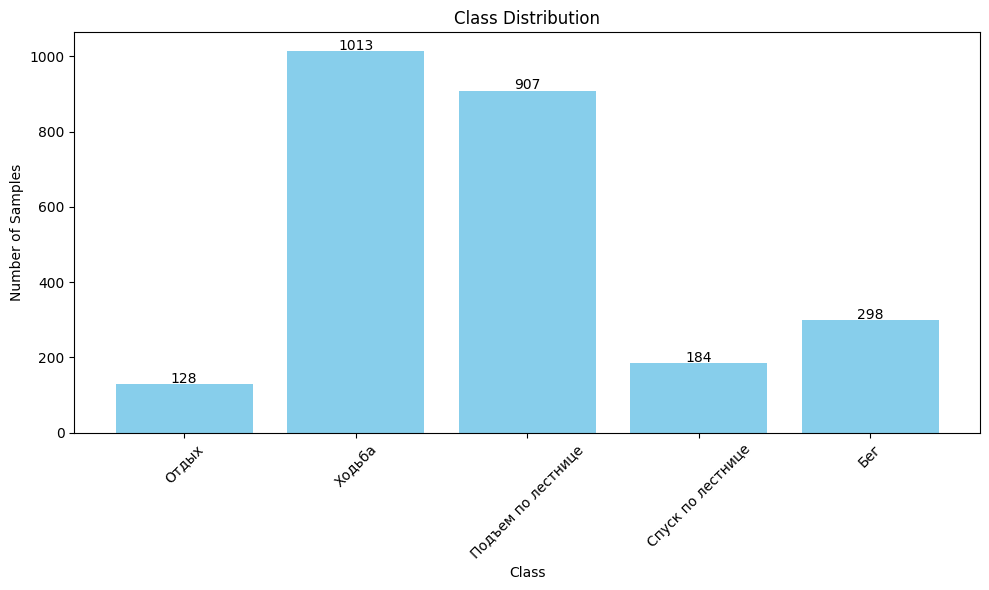


Running XGBoost pipeline...

========== XGBoost Model Pipeline ==========
Starting XGBoost model training...
[0]	train-mlogloss:1.38343	validation-mlogloss:1.38780
[100]	train-mlogloss:0.00406	validation-mlogloss:0.05735
[144]	train-mlogloss:0.00252	validation-mlogloss:0.05810
Training completed! Time: 3.39 seconds
Best iteration: 95
Test set accuracy: 0.9779
Weighted F1 score: 0.9785
F1 score for class 0 (Отдых): 0.7805
F1 score for class 1 (Ходьба): 0.9796
F1 score for class 2 (Подъем по лестнице): 0.9871
F1 score for class 3 (Спуск по лестнице): 0.9880
F1 score for class 4 (Бег): 1.0000


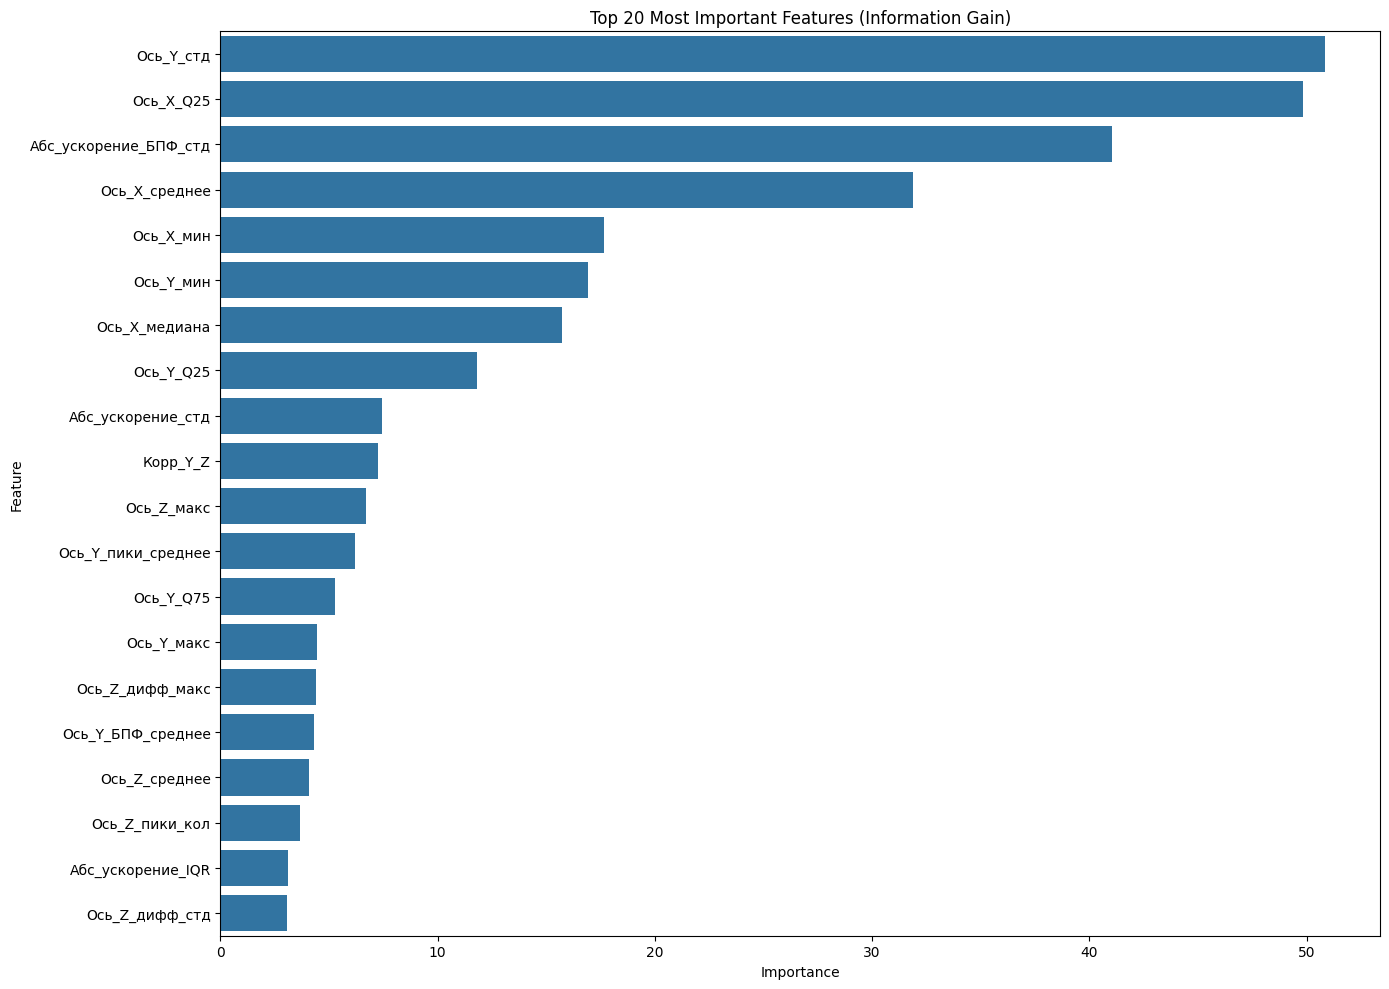

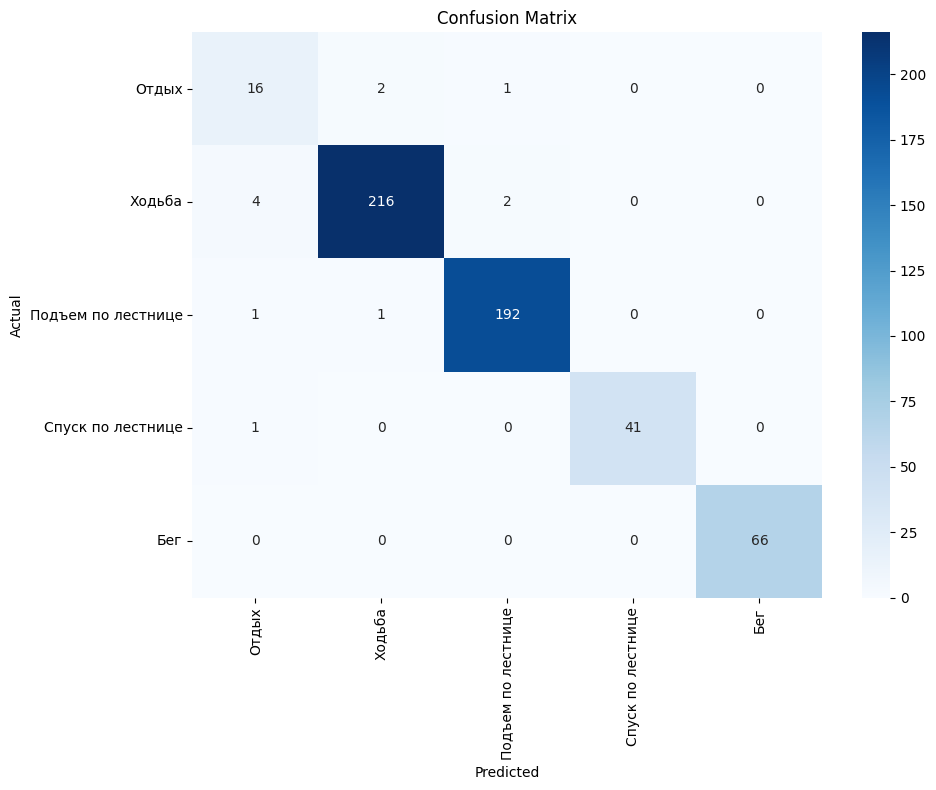

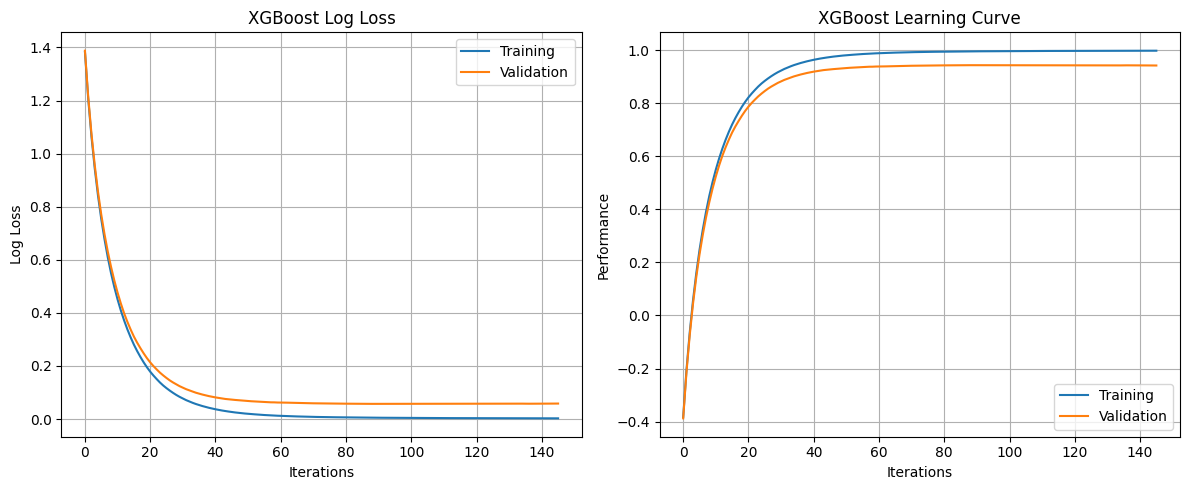

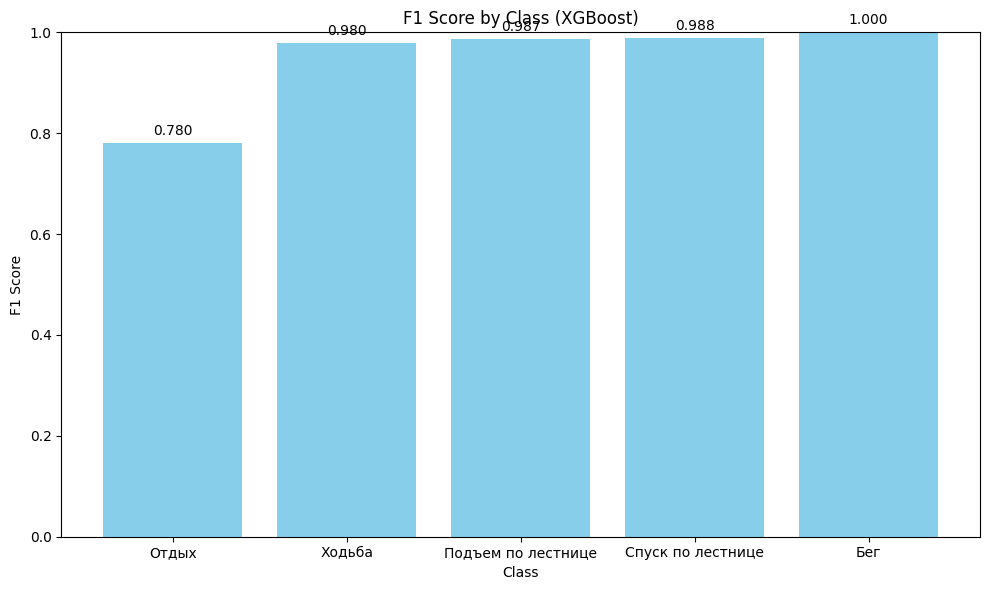

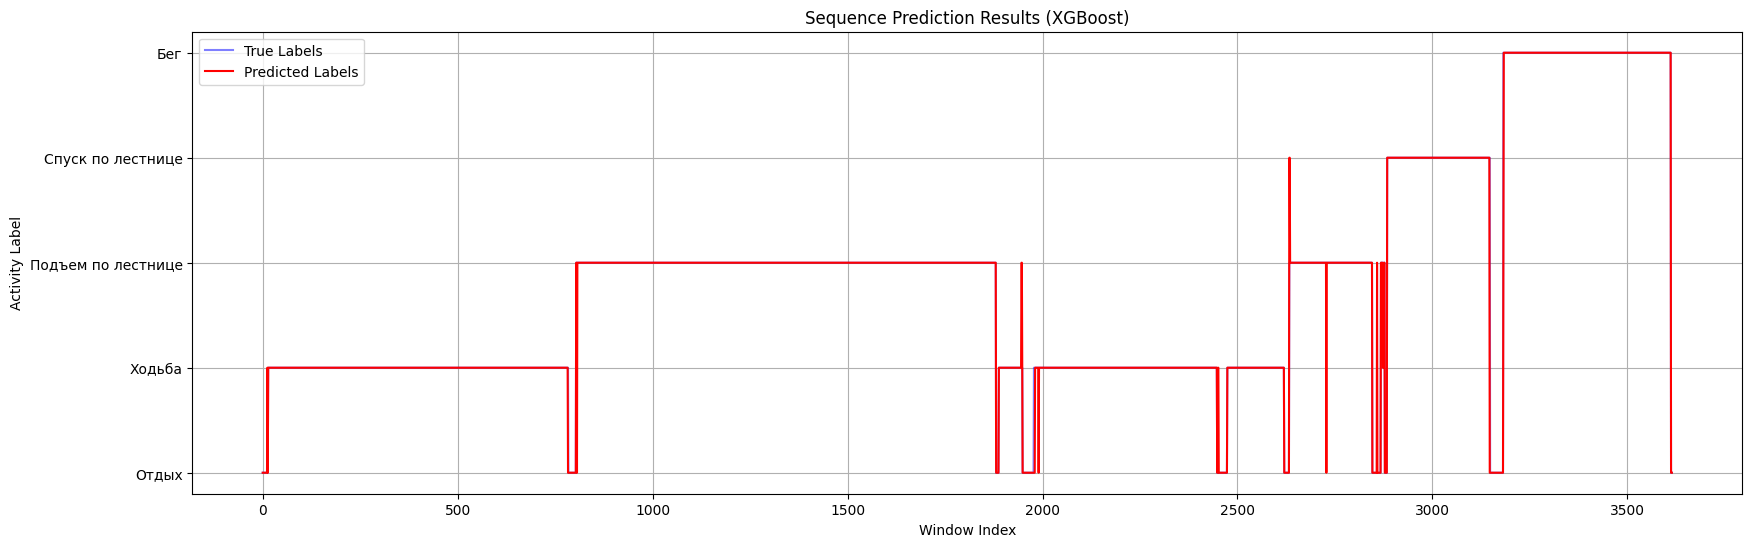

Sequence prediction accuracy: 0.9945
Model and scaler saved.

Running LightGBM pipeline...

========== LightGBM Model Pipeline ==========
GPU not detected, using CPU.
Starting LightGBM model training...
Training until validation scores don't improve for 50 rounds
[20]	train's multi_logloss: 0.350863	validation's multi_logloss: 0.373773
[40]	train's multi_logloss: 0.116321	validation's multi_logloss: 0.149909
[60]	train's multi_logloss: 0.0417892	validation's multi_logloss: 0.0850624
[80]	train's multi_logloss: 0.016638	validation's multi_logloss: 0.0687847
[100]	train's multi_logloss: 0.00747292	validation's multi_logloss: 0.0619589
[120]	train's multi_logloss: 0.00399583	validation's multi_logloss: 0.0618865
[140]	train's multi_logloss: 0.00247862	validation's multi_logloss: 0.0611045
[160]	train's multi_logloss: 0.00173261	validation's multi_logloss: 0.0616784
Early stopping, best iteration is:
[127]	train's multi_logloss: 0.00331923	validation's multi_logloss: 0.0604275
Training com

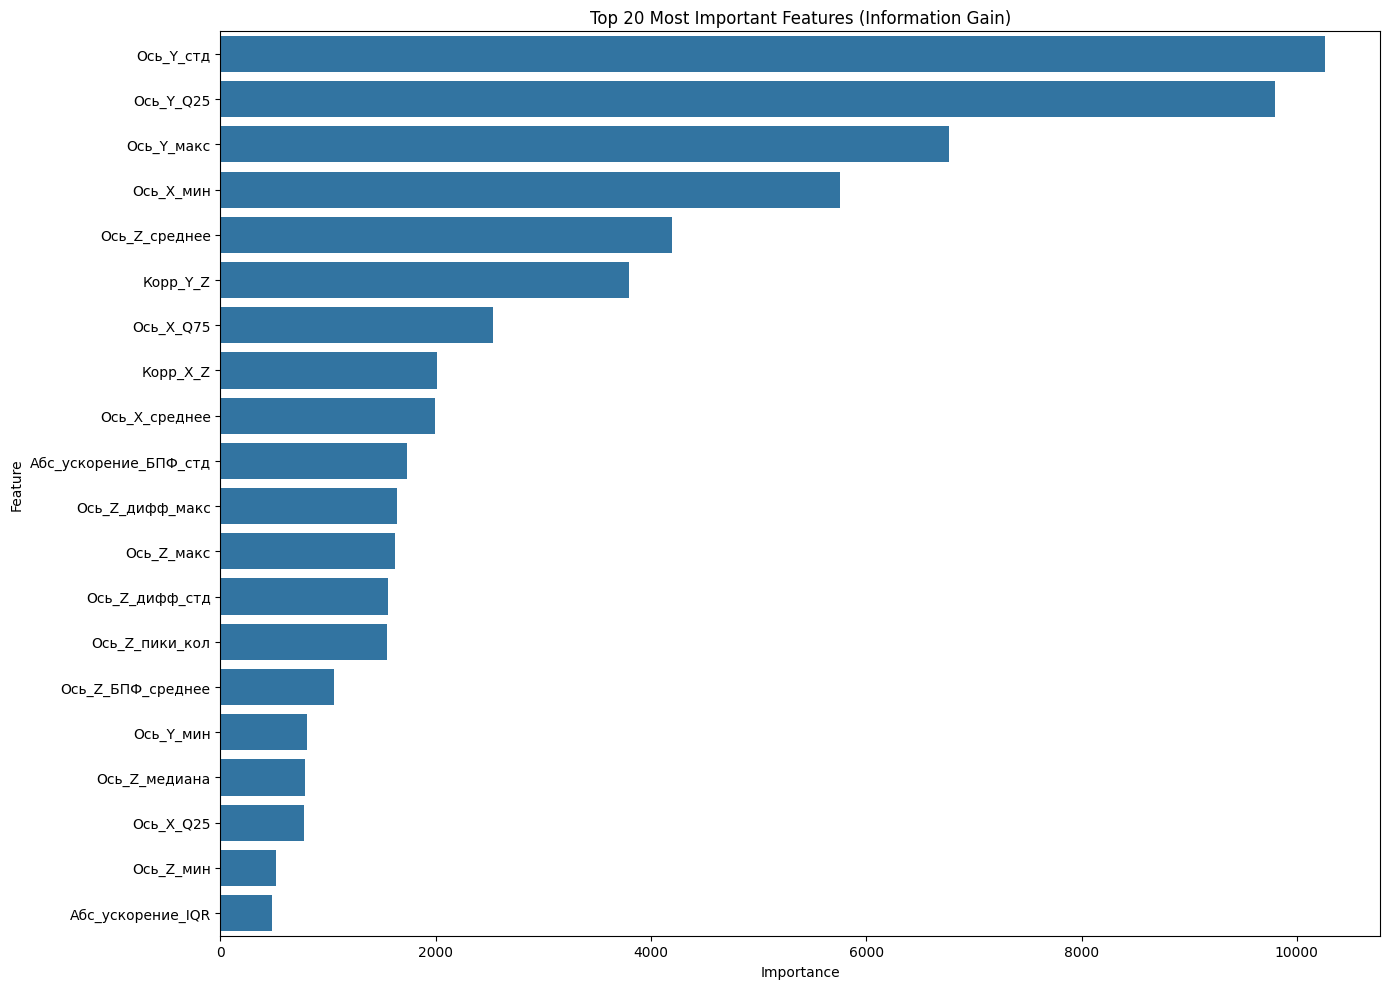

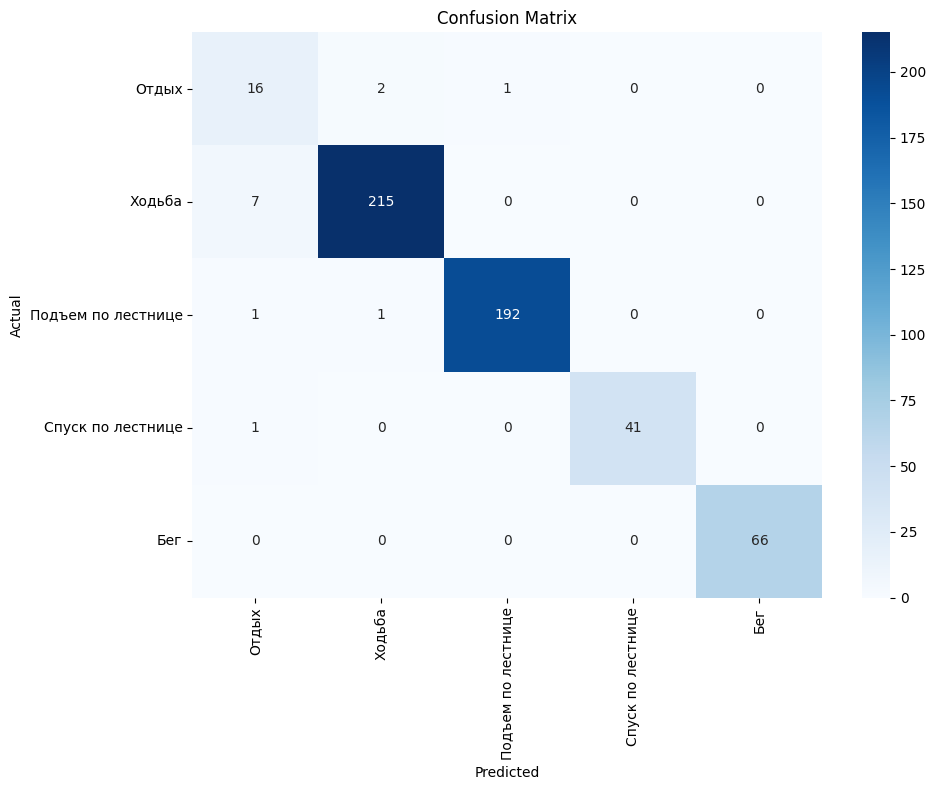

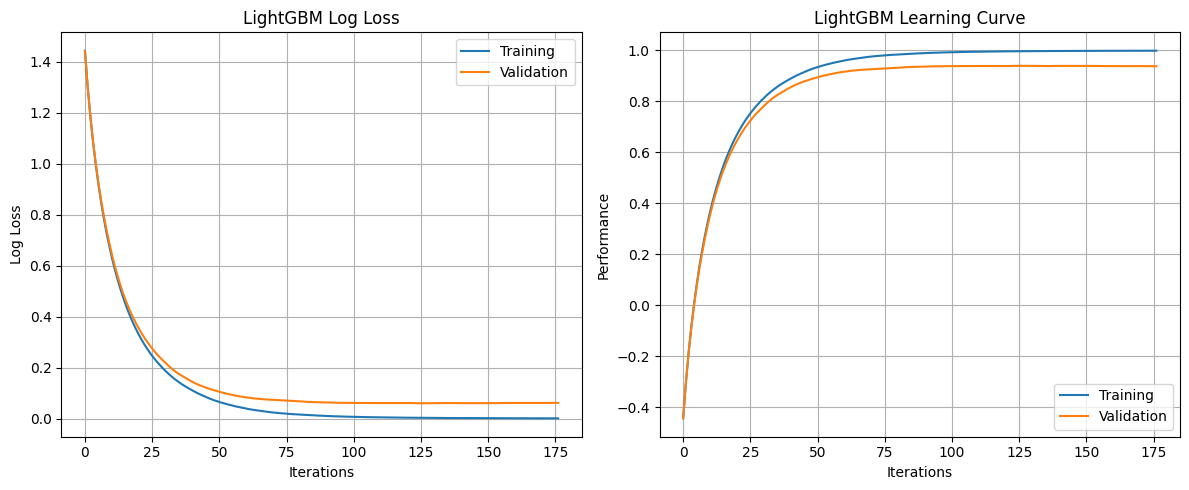

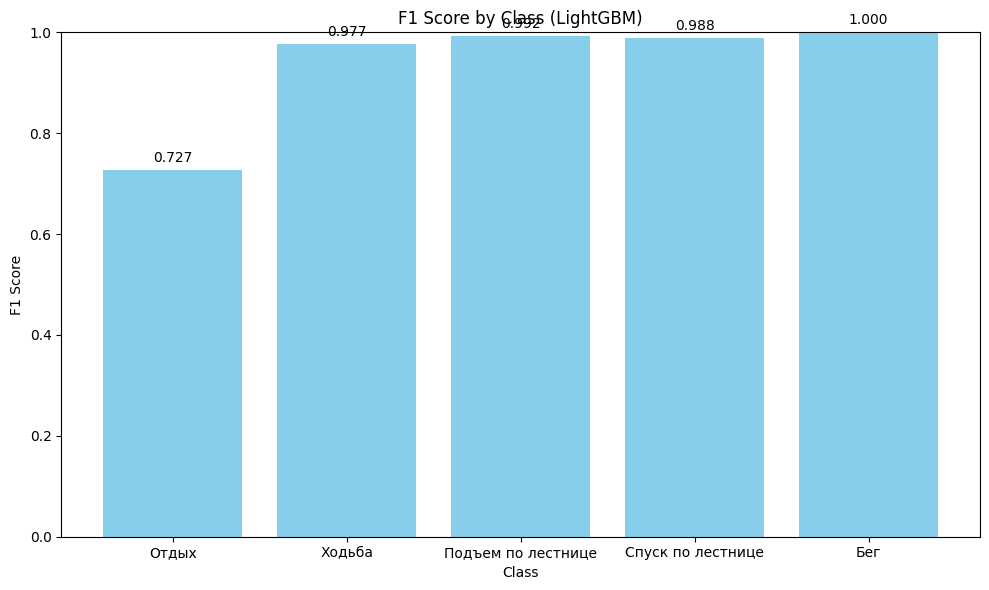

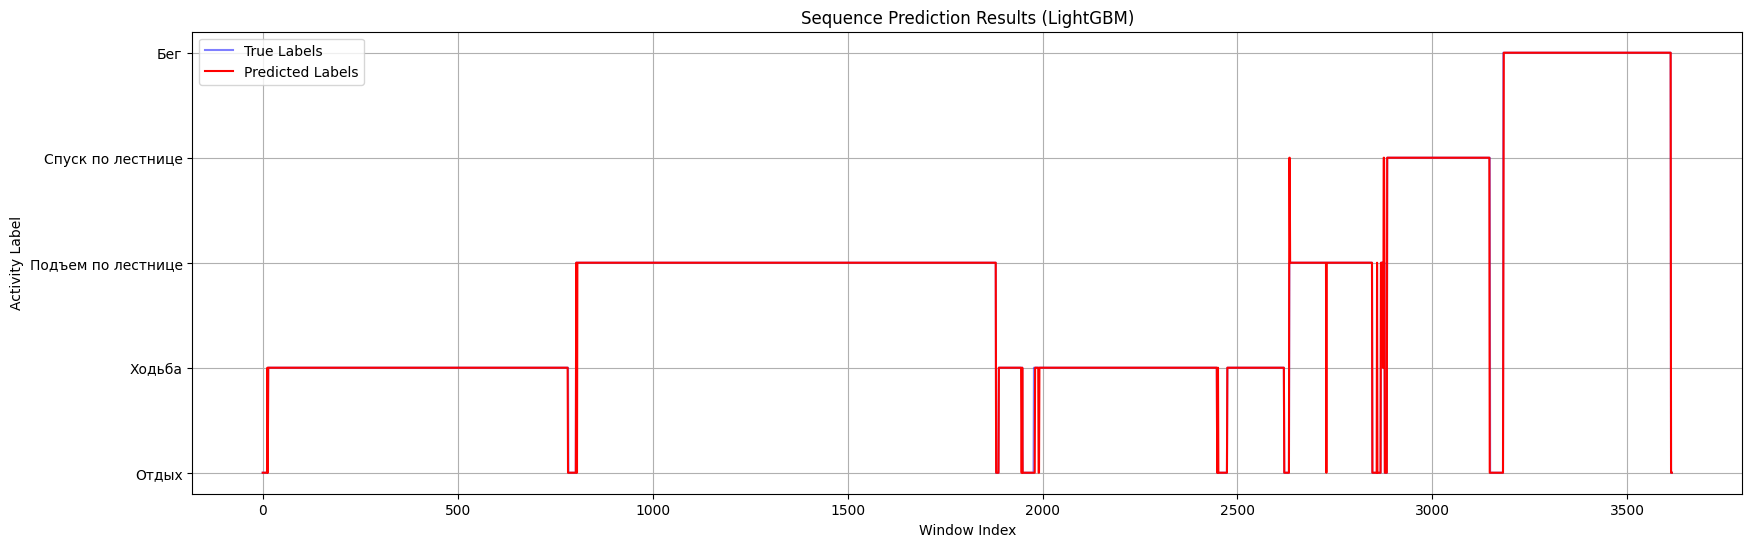

Sequence prediction accuracy: 0.9942
Model and scaler saved.

Running CNN pipeline...

========== CNN Model Pipeline ==========
Creating data loaders...
Training data shape after transposition: (2530, 4, 128)
Class weights: {np.float64(1.0): 0.20258992741473456, np.float64(0.0): 2.3018277472073168, np.float64(2.0): 0.22508935540494607, np.float64(4.0): 0.6647431168744087, np.float64(3.0): 1.6057498530985943}
Initializing CNN model...
GaitCNN(
  (input_conv): Conv1d(4, 32, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
  (input_bn): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res_block1): ResidualBlock(
    (conv1): Conv1d(32, 64, kernel_size=(5,), stride=(2,), padding=(2,), bias=False)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training CNN model...
Starting training for 50 epochs...
Epoch 1/50, Time: 7.78s, Train Loss: 0.5048, Train Acc: 0.6123, Val Loss: 0.6908, Val Acc: 0.3616, Val F1: 0.3378
Best model saved with F1: 0.3378
Epoch 2/50, Time: 8.56s, Train Loss: 0.2506, Train Acc: 0.7506, Val Loss: 0.5679, Val Acc: 0.6033, Val F1: 0.5075
Best model saved with F1: 0.5075
Epoch 3/50, Time: 6.98s, Train Loss: 0.2021, Train Acc: 0.7996, Val Loss: 0.5805, Val Acc: 0.7251, Val F1: 0.7548
Best model saved with F1: 0.7548
Epoch 4/50, Time: 8.55s, Train Loss: 0.1742, Train Acc: 0.8621, Val Loss: 0.3117, Val Acc: 0.9188, Val F1: 0.9315
Best model saved with F1: 0.9315
Epoch 5/50, Time: 6.99s, Train Loss: 0.1792, Train Acc: 0.9186, Val Loss: 0.1856, Val Acc: 0.9594, Val F1: 0.9630
Best model saved with F1: 0.9630
Epoch 6/50, Time: 8.55s, Train Loss: 0.1161, Train Acc: 0.9494, Val Loss: 0.1650, Val Acc: 0.9446, Val F1: 0.9519
F1 not improving: 1/10
Epoch 7/50, Time: 7.47s, Train Loss: 0.0799, Train Acc: 0.9688, Val Los

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 128, 64)   │        832 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 128, 64)   │      1,344 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128)  │        512 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128, 256)  │    263,168 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256)  │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 128, 128)  │    164,352 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128)  │        512 │ bidirectional_1[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128, 1)    │        129 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 1)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128)  │          0 │ dropout_2[0][0],  │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 5)         │        325 │ dropout_3[0][0] 

 Total params: 440,710 (1.68 MB)

 Trainable params: 439,558 (1.68 MB)

 Non-trainable params: 1,152 (4.50 KB)

Training LSTM model...
Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 859ms/step - accuracy: 0.8259 - f1_metric: 0.8260 - loss: 0.3382
Epoch 1: val_f1_metric improved from -inf to 0.96875, saving model to /content/lstm_results/best_lstm_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 87s 940ms/step - accuracy: 0.8270 - f1_metric: 0.8270 - loss: 0.3364 - val_accuracy: 0.9686 - val_f1_metric: 0.9688 - val_loss: 1.4838 - learning_rate: 0.0010
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9649 - f1_metric: 0.9649 - loss: 0.0837
Epoch 2: val_f1_metric improved from 0.96875 to 0.97426, saving model to /content/lstm_results/best_lstm_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 879ms/step - accuracy: 0.9649 - f1_metric: 0.9649 - loss: 0.0834 - val_accuracy: 0.9742 - val_f1_metric: 0.9743 - val_loss: 1.2827 - learning_rate: 0.0010
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.9741 - f1_metric: 0.9741 - loss: 0.0615
Epoch 3: val_f1_metric improved from 0.97426 to 0.98162, saving model to /content/lstm_results/best_lstm_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 70s 874ms/step - accuracy: 0.9741 - f1_metric: 0.9741 - loss: 0.0612 - val_accuracy: 0.9815 - val_f1_metric: 0.9816 - val_loss: 0.9973 - learning_rate: 0.0010
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 803ms/step - accuracy: 0.9756 - f1_metric: 0.9756 - loss: 0.0451
Epoch 4: val_f1_metric improved from 0.98162 to 0.98346, saving model to /content/lstm_results/best_lstm_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 870ms/step - accuracy: 0.9756 - f1_metric: 0.9756 - loss: 0.0450 - val_accuracy: 0.9834 - val_f1_metric: 0.9835 - val_loss: 0.6511 - learning_rate: 0.0010
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.9822 - f1_metric: 0.9822 - loss: 0.0400
Epoch 5: val_f1_metric improved from 0.98346 to 0.98897, saving model to /content/lstm_results/best_lstm_model.h5


80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 852ms/step - accuracy: 0.9822 - f1_metric: 0.9822 - loss: 0.0399 - val_accuracy: 0.9889 - val_f1_metric: 0.9890 - val_loss: 0.3021 - learning_rate: 0.0010
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.9858 - f1_metric: 0.9858 - loss: 0.0242
Epoch 6: val_f1_metric did not improve from 0.98897
80/80 ━━━━━━━━━━━━━━━━━━━━ 66s 827ms/step - accuracy: 0.9858 - f1_metric: 0.9858 - loss: 0.0241 - val_accuracy: 0.9871 - val_f1_metric: 0.9871 - val_loss: 0.1319 - learning_rate: 0.0010
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 811ms/step - accuracy: 0.9835 - f1_metric: 0.9835 - loss: 0.0279
Epoch 7: val_f1_metric did not improve from 0.98897
80/80 ━━━━━━━━━━━━━━━━━━━━ 69s 853ms/step - accuracy: 0.9835 - f1_metric: 0.9835 - loss: 0.0278 - val_accuracy: 0.9834 - val_f1_metric: 0.9835 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.9822 - f1_metric: 0.9822 - loss: 0.0388
Epoch 8: val_f1_m

80/80 ━━━━━━━━━━━━━━━━━━━━ 80s 831ms/step - accuracy: 0.9921 - f1_metric: 0.9921 - loss: 0.0079 - val_accuracy: 0.9908 - val_f1_metric: 0.9908 - val_loss: 0.0623 - learning_rate: 6.0000e-04
Epoch 16/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 787ms/step - accuracy: 0.9944 - f1_metric: 0.9944 - loss: 0.0047
Epoch 16: val_f1_metric did not improve from 0.99081
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 832ms/step - accuracy: 0.9944 - f1_metric: 0.9944 - loss: 0.0047 - val_accuracy: 0.9908 - val_f1_metric: 0.9908 - val_loss: 0.0615 - learning_rate: 6.0000e-04
Epoch 17/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 802ms/step - accuracy: 0.9958 - f1_metric: 0.9958 - loss: 0.0034
Epoch 17: val_f1_metric did not improve from 0.99081
80/80 ━━━━━━━━━━━━━━━━━━━━ 68s 843ms/step - accuracy: 0.9958 - f1_metric: 0.9958 - loss: 0.0034 - val_accuracy: 0.9908 - val_f1_metric: 0.9908 - val_loss: 0.0653 - learning_rate: 6.0000e-04
Epoch 18/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.9971 - f1_metric: 0.9971 - loss: 0.0033


80/80 ━━━━━━━━━━━━━━━━━━━━ 84s 875ms/step - accuracy: 0.9971 - f1_metric: 0.9971 - loss: 0.0033 - val_accuracy: 0.9926 - val_f1_metric: 0.9926 - val_loss: 0.0609 - learning_rate: 6.0000e-04
Epoch 19/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 812ms/step - accuracy: 0.9983 - f1_metric: 0.9983 - loss: 0.0027
Epoch 19: val_f1_metric did not improve from 0.99265
80/80 ━━━━━━━━━━━━━━━━━━━━ 82s 878ms/step - accuracy: 0.9983 - f1_metric: 0.9983 - loss: 0.0027 - val_accuracy: 0.9908 - val_f1_metric: 0.9908 - val_loss: 0.0668 - learning_rate: 6.0000e-04
Epoch 20/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 825ms/step - accuracy: 0.9983 - f1_metric: 0.9983 - loss: 0.0027
Epoch 20: val_f1_metric did not improve from 0.99265
80/80 ━━━━━━━━━━━━━━━━━━━━ 71s 890ms/step - accuracy: 0.9983 - f1_metric: 0.9983 - loss: 0.0027 - val_accuracy: 0.9908 - val_f1_metric: 0.9908 - val_loss: 0.0677 - learning_rate: 6.0000e-04
Epoch 21/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9983 - f1_metric: 0.9983 - loss: 0.0020


F1 score for class 0 (Отдых): 0.8444
F1 score for class 1 (Ходьба): 0.9864
F1 score for class 2 (Подъем по лестнице): 0.9948
F1 score for class 3 (Спуск по лестнице): 0.9880
F1 score for class 4 (Бег): 1.0000
ROC AUC: 0.9968
Model saved to: /content/lstm_results/final_lstm_model.h5
Scaler saved to: /content/lstm_results/lstm_scaler.joblib

Comparing all models...

========== Model Comparison ==========
Model Comparison:
      Model  Accuracy  F1 Score
0   XGBoost  0.977901  0.978451
1  LightGBM  0.976059  0.977464
2       CNN  0.972376  0.975175
3      LSTM  0.985267  0.986199


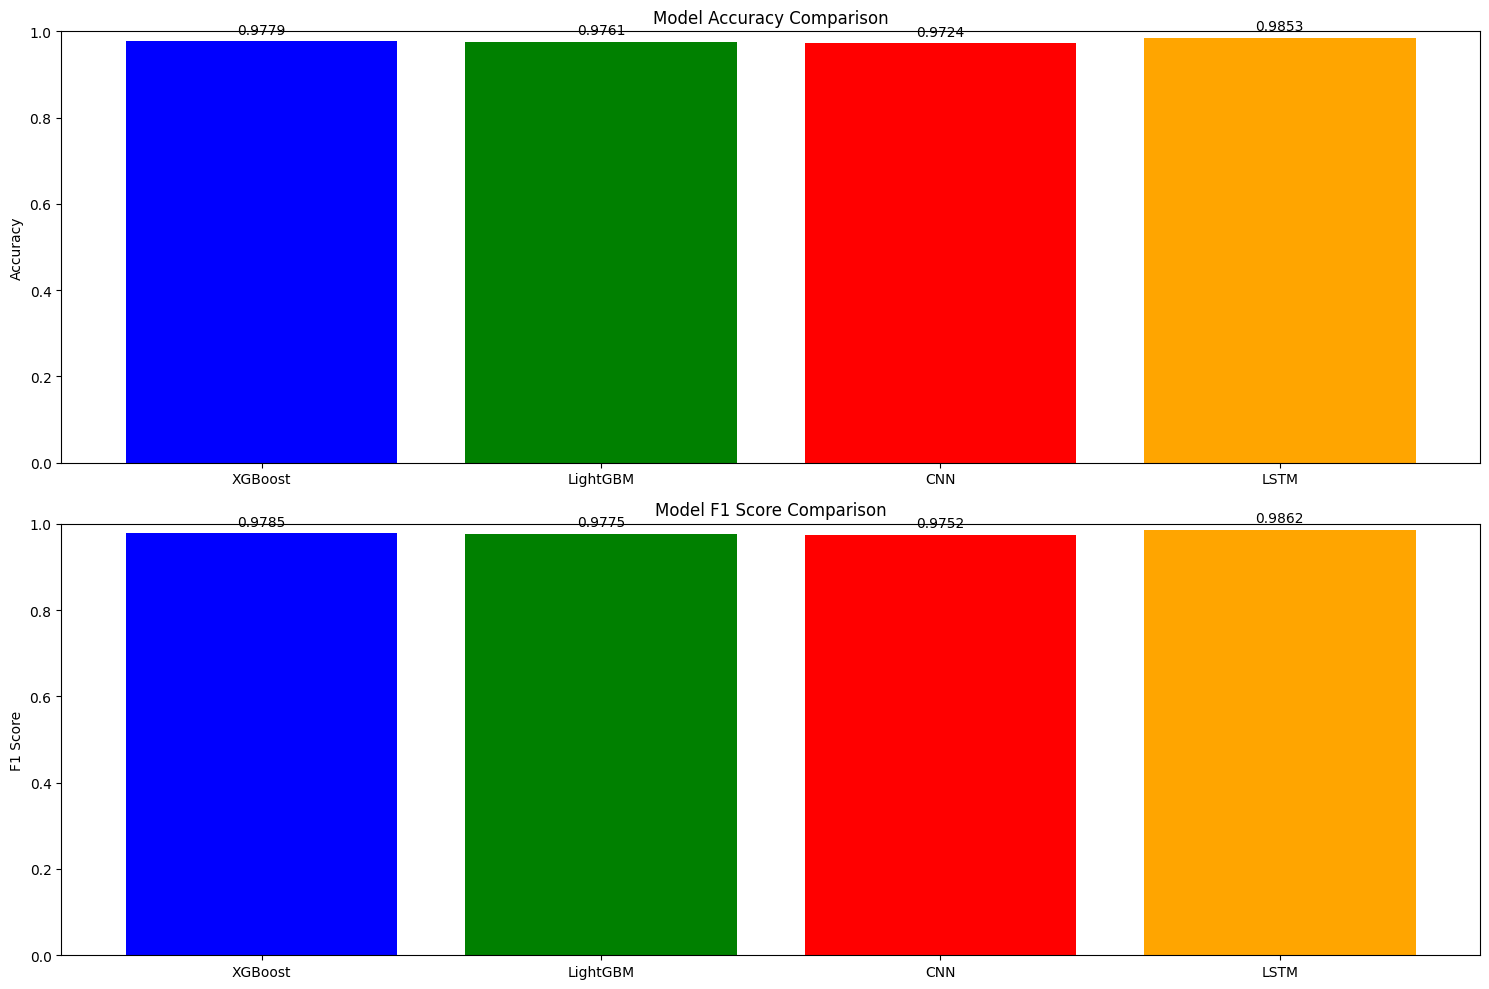

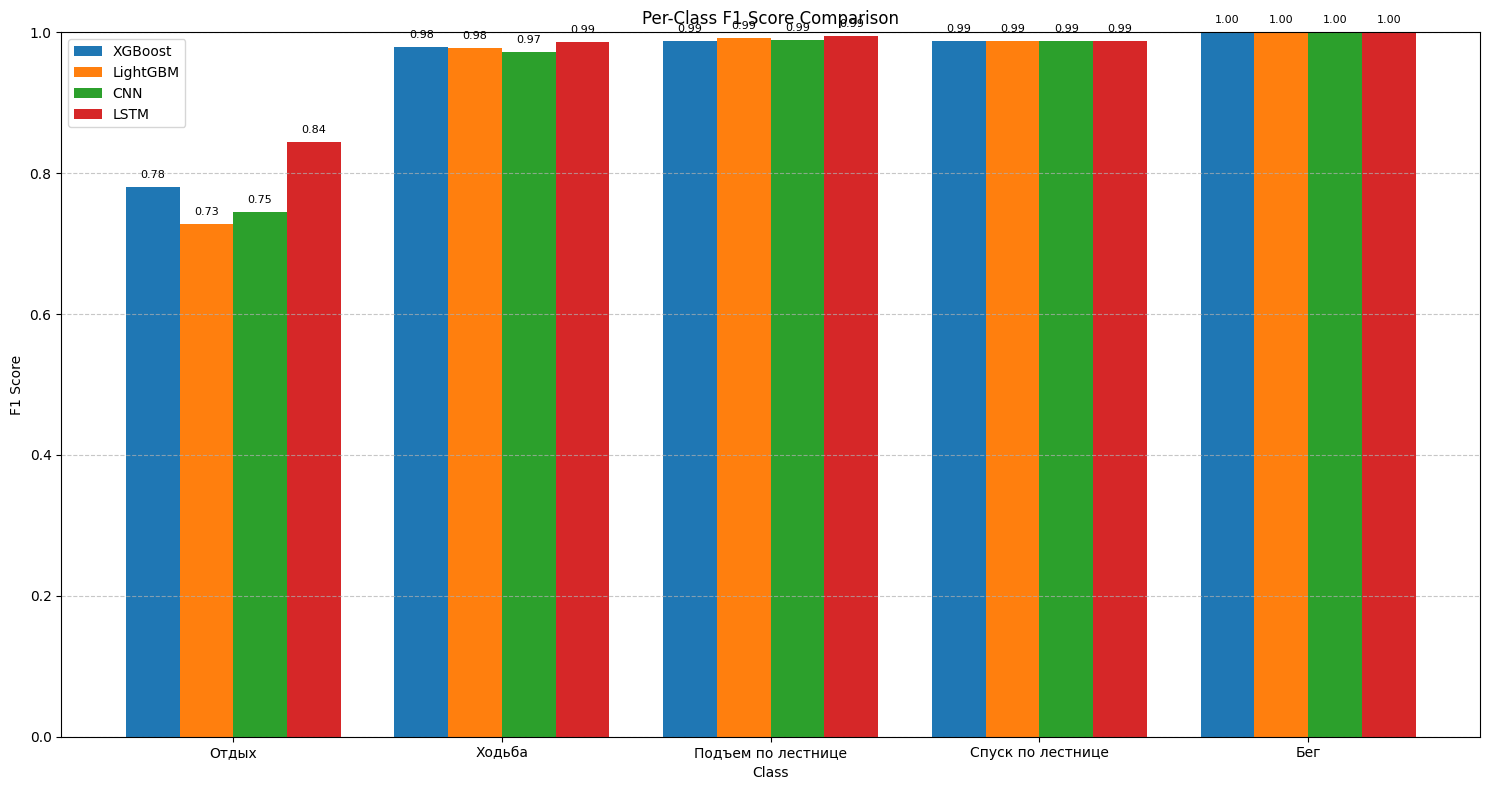


Best overall model: LSTM
Best model average F1 score: 0.9862
Best model per-class F1 scores: [0.8444444444444444, 0.9863636363636363, 0.9948186528497409, 0.9879518072289156, 1.0]

All pipelines completed!
Results saved to: /content/model_comparison


In [ ]:
def prepare_data(data_path, label_path, window_size, step_size):
    """
    Load, preprocess, and split data for all models.

    Args:
        data_path: Path to data directory
        label_path: Path to label directory
        window_size: Size of the sliding window
        step_size: Step size for the sliding window

    Returns:
        Dict containing all required data and features
    """
    print("\n========== Data Preparation ==========")
    print(f"Loading data from {data_path} and {label_path}...")

    # Load raw data
    X_stacked, y_stacked = load_and_stack_data(data_path, label_path)

    print(f"Raw data shape: {X_stacked.shape}")
    print(f"Raw labels shape: {y_stacked.shape}")

    # Create sliding window datasets
    print("\nCreating features dataset for tree-based models...")
    features_df, feature_labels = create_windowed_dataset_features(X_stacked, y_stacked, window_size, step_size)

    print(f"Features dataset shape: {features_df.shape}")
    print(f"Feature labels shape: {feature_labels.shape}")

    print("\nCreating sequences dataset for deep learning models...")
    sequences, sequence_labels = create_windowed_dataset_sequences(X_stacked, y_stacked, window_size, step_size)

    print(f"Sequences dataset shape: {sequences.shape}")
    print(f"Sequence labels shape: {sequence_labels.shape}")

    # Random shuffle indices for consistent train/val/test split
    print("\nSplitting datasets into train/validation/test sets...")
    indices = np.arange(len(features_df))
    np.random.seed(42)
    np.random.shuffle(indices)

    # Features for tree-based models
    X_features_shuffled = features_df.iloc[indices].reset_index(drop=True)
    y_features_shuffled = feature_labels[indices]

    # Sequences for deep learning models
    X_sequences_shuffled = sequences[indices]
    y_sequences_shuffled = sequence_labels[indices]

    # Split into train/validation/test
    # First split: 70% train, 30% temp
    X_features_train, X_features_temp, y_features_train, y_features_temp = train_test_split(
        X_features_shuffled, y_features_shuffled, test_size=0.3, random_state=42
    )

    # Second split: 15% validation, 15% test (50% of the 30% temp)
    X_features_val, X_features_test, y_features_val, y_features_test = train_test_split(
        X_features_temp, y_features_temp, test_size=0.5, random_state=42
    )

    # Same splits for sequences
    X_sequences_train, X_sequences_temp, y_sequences_train, y_sequences_temp = train_test_split(
        X_sequences_shuffled, y_sequences_shuffled, test_size=0.3, random_state=42
    )

    X_sequences_val, X_sequences_test, y_sequences_val, y_sequences_test = train_test_split(
        X_sequences_temp, y_sequences_temp, test_size=0.5, random_state=42
    )

    print(f"Training set: {len(X_features_train)} samples")
    print(f"Validation set: {len(X_features_val)} samples")
    print(f"Test set: {len(X_features_test)} samples")

    # Analyze class distribution
    analyze_class_distribution(y_features_train)

    # Return all data in a dictionary
    return {
        'raw': {
            'X': X_stacked,
            'y': y_stacked
        },
        'features': {
            'train': (X_features_train, y_features_train),
            'val': (X_features_val, y_features_val),
            'test': (X_features_test, y_features_test)
        },
        'sequences': {
            'train': (X_sequences_train, y_sequences_train),
            'val': (X_sequences_val, y_sequences_val),
            'test': (X_sequences_test, y_sequences_test)
        },
        'window_params': {
            'window_size': window_size,
            'step_size': step_size
        }
    }

def run_cnn_pipeline(data_dict):
    """
    Run the complete CNN model pipeline.

    Args:
        data_dict: Dictionary containing all prepared data

    Returns:
        Dictionary of evaluation results
    """
    print("\n========== CNN Model Pipeline ==========")

    # Get sequence data
    X_train, y_train = data_dict['sequences']['train']
    X_val, y_val = data_dict['sequences']['val']
    X_test, y_test = data_dict['sequences']['test']

    # Get raw data for sequence prediction
    X_raw = data_dict['raw']['X']
    y_raw = data_dict['raw']['y']

    # Get window parameters
    window_size = data_dict['window_params']['window_size']
    step_size = data_dict['window_params']['step_size']

    # Create data loaders
    print("Creating data loaders...")
    train_loader, val_loader, test_loader = create_dataloaders(
        X_train, y_train, X_val, y_val, X_test, y_test,
        batch_size=32, use_weighted_sampler=True
    )

    # Initialize model
    print("Initializing CNN model...")
    model = GaitCNN(input_channels=4, num_classes=5, dropout_rate=0.5).to(device)
    print(model)

    # Define loss function and optimizer
    # Calculate class weights
    class_weights_dict = create_class_weights(y_train)
    class_weights = torch.FloatTensor([class_weights_dict[i] for i in range(len(np.unique(y_train)))]).to(device)

    # Define weighted cross-entropy loss
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # Define optimizer and learning rate scheduler
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    # Train model
    print("Training CNN model...")
    model, history = train_cnn_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        num_epochs=50, patience=10, device=device
    )

    # Test model
    print("Evaluating CNN model on test set...")
    evaluation_results = test_cnn_model(model, test_loader, device)

    # Visualize results
    print("Visualizing results...")
    # Full visualization code would be here

    # Save model
    model_path = os.path.join(CNN_RESULTS_DIR, 'final_cnn_model.pth')
    torch.save(model.state_dict(), model_path)
    print(f"Model saved to: {model_path}")

    # Save evaluation results
    with open(os.path.join(CNN_RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        results = {
            'accuracy': float(evaluation_results['accuracy']),
            'f1_weighted': float(evaluation_results['f1_weighted']),
            'f1_per_class': evaluation_results['f1_per_class'].tolist(),
            'classification_report': evaluation_results['classification_report'],
            'confusion_matrix': evaluation_results['confusion_matrix'].tolist(),
        }

        if evaluation_results['auc_score'] is not None:
            results['auc_score'] = float(evaluation_results['auc_score'])

        json.dump(results, f, indent=4)

    return evaluation_results

def run_lstm_pipeline(data_dict):
    """
    Run the complete LSTM model pipeline using TensorFlow.

    Args:
        data_dict: Dictionary containing all prepared data

    Returns:
        Dictionary of evaluation results
    """
    print("\n========== LSTM Model Pipeline ==========")

    # Get sequence data
    X_train, y_train = data_dict['sequences']['train']
    X_val, y_val = data_dict['sequences']['val']
    X_test, y_test = data_dict['sequences']['test']

    # Get raw data for sequence prediction
    X_raw = data_dict['raw']['X']
    y_raw = data_dict['raw']['y']

    # Ensure labels are integer type
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)

    # Convert labels to one-hot encoding
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=5)
    y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=5)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=5)

    # Use RobustScaler for feature standardization
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val_scaled = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Get input shape and number of classes
    input_shape = (X_train.shape[1], X_train.shape[2])
    num_classes = 5  # 5 activity classes

    print(f"Input shape: {input_shape}")
    print(f"Number of classes: {num_classes}")

    # Define LSTM model architecture
    print("Creating LSTM model...")

    # Input layer
    inputs = Input(shape=input_shape)

    # Convolutional layers for feature extraction
    conv1 = Conv1D(64, kernel_size=3, padding='same', activation='relu')(inputs)
    conv2 = Conv1D(64, kernel_size=5, padding='same', activation='relu')(inputs)
    x = Concatenate()([conv1, conv2])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Second LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Attention mechanism
    attention = Dense(1, activation='tanh')(x)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention)
    context = Multiply()([x, attention])

    # Global pooling
    x = GlobalAveragePooling1D()(context)

    # Fully connected layers
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build model
    model = Model(inputs, outputs)

    # Define custom F1 score metric function
    def f1_metric(y_true, y_pred):
        """TensorFlow compatible F1 score calculation function."""
        # Get predicted class
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_true_classes = tf.argmax(y_true, axis=1)

        # Convert to float
        y_pred_classes = tf.cast(y_pred_classes, tf.float32)
        y_true_classes = tf.cast(y_true_classes, tf.float32)

        # Calculate TP
        true_positives = tf.reduce_sum(tf.cast(y_pred_classes == y_true_classes, tf.float32))

        # Add smoothing factor to avoid division by zero
        smooth = tf.constant(1e-7, dtype=tf.float32)

        # Calculate precision and recall
        precision = true_positives / (tf.reduce_sum(tf.ones_like(y_pred_classes)) + smooth)
        recall = true_positives / (tf.reduce_sum(tf.ones_like(y_true_classes)) + smooth)

        # Calculate F1 score
        f1 = 2 * precision * recall / (precision + recall + smooth)

        return f1

    # Calculate class weights
    class_weights = create_class_weights(y_train)

    # Optimizer
    optimizer = Adam(learning_rate=0.001)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy', f1_metric]
    )

    # Display model summary
    model.summary()

    # Define callbacks
    callbacks = [
        # Learning rate scheduler
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.6,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        # Early stopping
        EarlyStopping(
            monitor='val_f1_metric',
            patience=15,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        # Model checkpoint
        ModelCheckpoint(
            filepath=os.path.join(LSTM_RESULTS_DIR, "best_lstm_model.h5"),
            monitor='val_f1_metric',
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train model
    print("Training LSTM model...")
    history = model.fit(
        X_train_scaled, y_train_onehot,
        validation_data=(X_val_scaled, y_val_onehot),
        epochs=100,
        batch_size=32,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    # Evaluate model
    print("Evaluating LSTM model on test set...")
    test_loss, test_accuracy, test_f1 = model.evaluate(X_test_scaled, y_test_onehot, verbose=1)

    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test F1 score: {test_f1:.4f}")

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_onehot, axis=1)

    # Calculate detailed metrics
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    class_f1 = f1_score(y_test_classes, y_pred_classes, average=None)

    # Output F1 score for each class
    for i, score in enumerate(class_f1):
        print(f"F1 score for class {i} ({CLASS_NAMES[i]}): {score:.4f}")

    # Calculate confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    # Calculate ROC AUC
    try:
        auc_score = roc_auc_score(y_test_onehot, y_pred, multi_class='ovr')
        print(f"ROC AUC: {auc_score:.4f}")
    except Exception as e:
        print(f"Error calculating ROC AUC: {e}")
        auc_score = None

    # Save model and scaler
    model_path = os.path.join(LSTM_RESULTS_DIR, "final_lstm_model.h5")
    model.save(model_path)
    scaler_path = os.path.join(LSTM_RESULTS_DIR, "lstm_scaler.joblib")
    joblib.dump(scaler, scaler_path)

    print(f"Model saved to: {model_path}")
    print(f"Scaler saved to: {scaler_path}")

    # Create evaluation results dictionary
    evaluation_results = {
        "accuracy": test_accuracy,
        "f1_score": f1,
        "f1_per_class": class_f1.tolist(),
        "confusion_matrix": cm.tolist(),
        "auc_score": auc_score,
        "predictions": y_pred_classes.tolist(),
        "true_labels": y_test_classes.tolist()
    }

    # Save evaluation results
    with open(os.path.join(LSTM_RESULTS_DIR, 'evaluation_results.json'), 'w') as f:
        json.dump(evaluation_results, f, indent=4)

    return evaluation_results, history, model, scaler

def compare_all_models(results_dict):
    """
    Compare all models and visualize their performance.

    Args:
        results_dict: Dictionary containing results from all models
    """
    print("\n========== Model Comparison ==========")

    # Prepare data for comparison
    models = []
    accuracies = []
    f1_scores = []
    f1_per_class_list = []

    # Add results for each model if available
    if 'xgboost' in results_dict:
        models.append('XGBoost')
        accuracies.append(results_dict['xgboost']['accuracy'])
        f1_scores.append(results_dict['xgboost']['f1_score'])
        f1_per_class_list.append(results_dict['xgboost']['f1_per_class'])

    if 'lightgbm' in results_dict:
        models.append('LightGBM')
        accuracies.append(results_dict['lightgbm']['accuracy'])
        f1_scores.append(results_dict['lightgbm']['f1_score'])
        f1_per_class_list.append(results_dict['lightgbm']['f1_per_class'])

    if 'cnn' in results_dict:
        models.append('CNN')
        accuracies.append(results_dict['cnn']['accuracy'])
        f1_scores.append(results_dict['cnn']['f1_weighted'])
        f1_per_class_list.append(results_dict['cnn']['f1_per_class'])

    if 'lstm' in results_dict:
        models.append('LSTM')
        accuracies.append(results_dict['lstm']['accuracy'])
        f1_scores.append(results_dict['lstm']['f1_score'])
        f1_per_class_list.append(results_dict['lstm']['f1_per_class'])

    # Create DataFrame for the comparison
    comparison_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'F1 Score': f1_scores
    })

    print("Model Comparison:")
    print(comparison_df)

    # Save comparison to CSV
    comparison_df.to_csv(os.path.join(COMPARISON_DIR, 'model_comparison.csv'), index=False)

    # Visualize comparison

    # 1. Accuracy and F1 score comparison
    plt.figure(figsize=(15, 10))

    # Accuracy comparison
    plt.subplot(2, 1, 1)
    bars = plt.bar(models, accuracies, color=['blue', 'green', 'red', 'orange'][:len(models)])
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    # F1 score comparison
    plt.subplot(2, 1, 2)
    bars = plt.bar(models, f1_scores, color=['blue', 'green', 'red', 'orange'][:len(models)])
    plt.title('Model F1 Score Comparison')
    plt.ylabel('F1 Score')
    plt.ylim(0, 1)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.4f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(os.path.join(COMPARISON_DIR, 'model_performance_comparison.png'))
    plt.show()

    # 2. Per-class F1 score comparison
    plt.figure(figsize=(15, 8))

    # Set width and positions
    num_models = len(models)
    num_classes = len(f1_per_class_list[0])
    width = 0.8 / num_models

    # Plot F1 score for each model by class
    for i, (model, f1_per_class) in enumerate(zip(models, f1_per_class_list)):
        x = np.arange(num_classes) + i * width - (num_models-1) * width / 2
        bars = plt.bar(x, f1_per_class, width=width, label=model)

        # Add values on bars
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.2f}', ha='center', va='bottom', fontsize=8)

    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    plt.title('Per-Class F1 Score Comparison')
    plt.xticks(np.arange(num_classes), CLASS_NAMES)
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.savefig(os.path.join(COMPARISON_DIR, 'per_class_f1_comparison.png'))
    plt.show()

    # 3. Best model recommendation
    avg_f1_scores = []
    for i, model in enumerate(models):
        avg_f1 = f1_scores[i]
        min_class_f1 = min(f1_per_class_list[i])
        # Consider both average F1 and worst-class F1
        combined_score = 0.7 * avg_f1 + 0.3 * min_class_f1
        avg_f1_scores.append(combined_score)

    best_model_idx = np.argmax(avg_f1_scores)
    best_model = models[best_model_idx]

    print(f"\nBest overall model: {best_model}")
    print(f"Best model average F1 score: {f1_scores[best_model_idx]:.4f}")
    print(f"Best model per-class F1 scores: {f1_per_class_list[best_model_idx]}")

    # Save best model info
    with open(os.path.join(COMPARISON_DIR, 'best_model.txt'), 'w') as f:
        f.write(f"Best model: {best_model}\n")
        f.write(f"Accuracy: {accuracies[best_model_idx]:.4f}\n")
        f.write(f"F1 Score: {f1_scores[best_model_idx]:.4f}\n")
        f.write(f"Per-class F1 scores: {f1_per_class_list[best_model_idx]}\n")

    return {
        'comparison_df': comparison_df,
        'best_model': best_model,
        'best_model_idx': best_model_idx
    }

def main():
    """Main function to run the entire pipeline."""
    print("==========================================================")
    print("       Gait Recognition with Multiple ML Models")
    print("==========================================================")

    # First, mount Google Drive and extract the dataset
    print("\n========== Setting Up Dataset ==========")
    try:
        from google.colab import drive
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
    except Exception as e:
        print(f"Note: Unable to mount Google Drive: {e}")
        print("Continuing without Google Drive mount...")

    # Extract dataset from zip file
    import zipfile

    # Define dataset paths
    dataset_zip_path = '/content/dataset-gait.zip'
    dataset_extract_path = '/content'
    data_path = '/content/dataset-gait/data'
    label_path = '/content/dataset-gait/label'

    # Check if dataset zip exists
    if os.path.exists(dataset_zip_path):
        print(f"Found dataset zip at {dataset_zip_path}")
        print("Extracting dataset...")
        with zipfile.ZipFile(dataset_zip_path, 'r') as zip_ref:
            zip_ref.extractall(dataset_extract_path)
        print("Dataset extracted successfully!")
    else:
        print(f"Warning: Dataset zip not found at {dataset_zip_path}")
        print("Please ensure the dataset zip file is available.")
        return

    # Verify dataset directories exist
    if not os.path.exists(data_path) or not os.path.exists(label_path):
        print(f"Warning: Dataset directories not found!")
        print(f"Data path: {data_path}")
        print(f"Label path: {label_path}")

        # Show the extracted file structure to help debug
        print("Extracted file structure:")
        for root, dirs, files in os.walk('/content/dataset-gait'):
            print(f"Directory: {root}")
            print(f"Subdirectories: {dirs}")
            print(f"Number of files: {len(files)}")

        return

    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    tf.random.set_seed(42)

    # Set parameters
    window_size = 128
    step_size = 64

    # Prepare data
    data_dict = prepare_data(data_path, label_path, window_size, step_size)

    # Dictionary to store results from all models
    results_dict = {}

    # Run XGBoost pipeline
    try:
        print("\nRunning XGBoost pipeline...")
        X_train, y_train = data_dict['features']['train']
        X_val, y_val = data_dict['features']['val']
        X_test, y_test = data_dict['features']['test']
        X_raw, y_raw = data_dict['raw']['X'], data_dict['raw']['y']

        xgb_results = run_xgboost_pipeline(
            X_train, y_train, X_val, y_val, X_test, y_test,
            X_raw, y_raw, window_size, step_size
        )
        results_dict['xgboost'] = xgb_results
    except Exception as e:
        print(f"Error in XGBoost pipeline: {e}")

    # Run LightGBM pipeline
    try:
        print("\nRunning LightGBM pipeline...")
        X_train, y_train = data_dict['features']['train']
        X_val, y_val = data_dict['features']['val']
        X_test, y_test = data_dict['features']['test']
        X_raw, y_raw = data_dict['raw']['X'], data_dict['raw']['y']

        lgbm_results = run_lgbm_pipeline(
            X_train, y_train, X_val, y_val, X_test, y_test,
            X_raw, y_raw, window_size, step_size
        )
        results_dict['lightgbm'] = lgbm_results
    except Exception as e:
        print(f"Error in LightGBM pipeline: {e}")

    # Run CNN pipeline
    try:
        print("\nRunning CNN pipeline...")
        cnn_results = run_cnn_pipeline(data_dict)
        results_dict['cnn'] = cnn_results
    except Exception as e:
        print(f"Error in CNN pipeline: {e}")

    # Run LSTM pipeline
    try:
        print("\nRunning LSTM pipeline...")
        lstm_results, history, lstm_model, lstm_scaler = run_lstm_pipeline(data_dict)
        results_dict['lstm'] = lstm_results
    except Exception as e:
        print(f"Error in LSTM pipeline: {e}")

    # Compare all models
    try:
        print("\nComparing all models...")
        comparison_results = compare_all_models(results_dict)

        # Save complete results
        with open(os.path.join(COMPARISON_DIR, 'all_results.json'), 'w') as f:
            # Convert any numpy arrays to lists for JSON serialization
            serializable_results = {}
            for model, results in results_dict.items():
                serializable_results[model] = {}
                for key, value in results.items():
                    if isinstance(value, np.ndarray):
                        serializable_results[model][key] = value.tolist()
                    elif isinstance(value, np.float32) or isinstance(value, np.float64):
                        serializable_results[model][key] = float(value)
                    else:
                        serializable_results[model][key] = value

            json.dump(serializable_results, f, indent=4)
    except Exception as e:
        print(f"Error in model comparison: {e}")

    print("\nAll pipelines completed!")
    print(f"Results saved to: {COMPARISON_DIR}")

    return results_dict

if __name__ == "__main__":
    main()